# AB InBev Hackathon competition 2023

# Model training

In [1]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import optuna

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import numpy as np
import pandas as pd
from itertools import product

import shap

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Macroeconomic data 

In [2]:
macro_df = pd.read_excel("macro_data.xlsx")
macro_df.head()

,Year,Month,Retail_Sales_Index,Unemployment_Rate,CPI,Private_Consumption,Gross_Domestic_Saving,Brad_Money,GDP
0,2018,1,94.421620,9.775006,95.274254,585354.10,129255.0,473557.20,844594.5
1,2018,2,92.811650,9.775006,95.484870,585354.10,129255.0,473557.20,844594.5
2,2018,3,93.475586,9.775006,95.604520,585354.10,129255.0,473557.20,844594.5
3,2018,4,96.537200,9.690458,95.866320,589451.94,129255.0,475877.16,849531.8
4,2018,5,96.273380,9.690458,96.200226,589451.94,129255.0,475877.16,849531.8


### Constraints datasets

In [3]:
vol_var_const_df = pd.read_excel("volume_variation_constraint_hackathon.xlsx")
vol_var_const_df.head()

,SKU,Brand,Pack,Size,Minimum Volume Variation,Maximum Volume Variation
0,jpXhdU,LoYUOg,mmgsXK,StircS,-0.595874,0.365638
1,ykzJnG,OmUaam,mmgsXK,CTOGzl,-0.389015,0.298220
2,mFEENn,YZfPPf,gydWlH,StircS,-0.384432,0.343191
3,EWpIvF,ddBknG,mmgsXK,StircS,-0.383206,0.309620
4,NDjGwG,aYZJQW,VmwBmS,pKILVK,-0.382353,0.245059


In [4]:
max_discount_const_brand = pd.read_excel("maximum_discount_constraint_hackathon.xlsx", sheet_name="Brand")
max_discount_const_pack = pd.read_excel("maximum_discount_constraint_hackathon.xlsx", sheet_name="Pack")
max_discount_const_price_segment = pd.read_excel("maximum_discount_constraint_hackathon.xlsx", sheet_name="PriceSegment")
max_discount_const_brand.head()

,Year,Month,Brand,max_discount
0,2023,6,FPgJHY,-2.340258e+08
1,2023,6,FnpxCq,-1.077114e+08
2,2023,6,JKAQQU,-1.969668e+09
3,2023,6,JcucVL,-2.169168e+07
4,2023,6,LoYUOg,-2.792598e+08


In [5]:
max_discount_const_pack

,Year,Month,Pack,max_discount
0,2023,6,GUbqnp,-3.830511e+10
1,2023,6,VmwBmS,-4.456805e+07
2,2023,6,gydWlH,-1.185722e+10
3,2023,6,mmgsXK,-1.313038e+10
4,2023,6,rwGJlW,-2.538664e+08
5,2023,7,GUbqnp,-3.824104e+10
6,2023,7,VmwBmS,-3.855361e+07
7,2023,7,gydWlH,-1.306834e+10
8,2023,7,mmgsXK,-1.336721e+10
9,2023,7,rwGJlW,-1.472351e+08


In [6]:
max_discount_const_price_segment

,Year,Month,PriceSegment,max_discount
0,2023,6,FkcKlo,-7.075328e+09
1,2023,6,qtUPAJ,-4.217010e+09
2,2023,6,rBvOre,-1.402168e+10
3,2023,6,zLdfYx,-3.566363e+10
4,2023,7,FkcKlo,-7.727772e+09
5,2023,7,qtUPAJ,-4.535993e+09
6,2023,7,rBvOre,-1.569308e+10
7,2023,7,zLdfYx,-3.560526e+10


#### Bridge dataset

In [7]:
brand_price_segment = pd.read_excel("brand_segment_mapping_hackathon.xlsx")
brand_price_segment.head()

,Brand,PriceSegment
0,OmUaam,zLdfYx
1,vAKBcH,zLdfYx
2,zOdJbd,zLdfYx
3,ZWPpTt,zLdfYx
4,wXKDHy,FkcKlo


### Sales dataset

In [8]:
sales_df = pd.read_excel("sales_data_hackathon.xlsx")
sales_df.head()

,Year,Month,SKU,Brand,Pack,Size,Volume_Htls,GTO_LC,Promotional_Discount_LC,Other_Discounts_LC,Total_Discounts_LC,Excise_LC,Net_Revenue_LC,MACO_LC,VILC_LC
0,2019,1,cpENXe,OmUaam,VmwBmS,KNdNVg,242.65,90960986.88,0.00,-598256.84,-598256.84,-27384810.42,62977919.62,47536325.82,15441593.80
1,2019,2,cpENXe,OmUaam,VmwBmS,KNdNVg,243.38,90879757.60,0.00,-567777.63,-567777.63,-29352431.76,60959548.21,46750059.93,14209488.28
2,2019,3,cpENXe,OmUaam,VmwBmS,KNdNVg,249.26,94582301.14,102941.18,-640085.92,-537144.74,-27528709.10,66516447.30,52233823.96,14282623.34
3,2019,4,cpENXe,OmUaam,VmwBmS,KNdNVg,199.26,75426202.79,43882.26,-291410.47,-247528.21,-21227275.99,53951398.59,44398209.76,9553188.83
4,2019,5,cpENXe,OmUaam,VmwBmS,KNdNVg,252.94,96540073.40,-268424.90,-472154.70,-740579.60,-26991176.48,68808317.32,57159490.21,11648827.11


### Description Sales DataSet

In [9]:
sales_df.describe()

,Year,Month,Volume_Htls,GTO_LC,Promotional_Discount_LC,Other_Discounts_LC,Total_Discounts_LC,Excise_LC,Net_Revenue_LC,MACO_LC,VILC_LC
count,10909.000000,10909.000000,10625.000000,1.062500e+04,1.090900e+04,1.090900e+04,1.090900e+04,1.062500e+04,1.062500e+04,1.062500e+04,1.062500e+04
mean,2020.569896,6.224585,7362.156558,3.264790e+09,-6.171155e+07,-1.661297e+08,-2.278412e+08,-7.964146e+08,2.245764e+09,1.410705e+09,8.350584e+08
std,1.282658,3.396996,32803.837126,1.403296e+10,4.383433e+08,6.635861e+08,9.009031e+08,3.636506e+09,9.769295e+09,7.002067e+09,2.987064e+09
min,2019.000000,1.000000,-742.240000,-1.208562e+08,-1.148901e+10,-1.304530e+10,-1.658946e+10,-6.027456e+10,-7.261576e+08,-2.948698e+09,-1.406787e+08
25%,2019.000000,3.000000,0.000000,-7.077700e+03,-1.048318e+06,-4.686279e+07,-6.101947e+07,-1.615535e+08,-7.904280e+03,-1.356312e+04,-7.275958e-12
50%,2020.000000,6.000000,35.500000,2.001083e+07,0.000000e+00,-1.033579e+06,-1.541066e+06,-1.413785e+05,1.293246e+07,2.023577e+06,7.627740e+06
75%,2022.000000,9.000000,1791.460000,8.585799e+08,0.000000e+00,0.000000e+00,0.000000e+00,3.790600e+02,5.670107e+08,1.958151e+08,2.976505e+08
max,2023.000000,12.000000,523596.690000,2.409457e+11,4.303213e+07,4.417828e+09,3.270244e+09,6.698526e+08,1.799523e+11,1.351081e+11,4.484423e+10


In [10]:
len(sales_df.SKU.unique())

444

In [11]:
sales_df.isnull().sum()

Year                         0
Month                        0
SKU                          0
Brand                        0
Pack                         0
Size                         0
Volume_Htls                284
GTO_LC                     284
Promotional_Discount_LC      0
Other_Discounts_LC           0
Total_Discounts_LC           0
Excise_LC                  284
Net_Revenue_LC             284
MACO_LC                    284
VILC_LC                    284
dtype: int64

In [12]:
#sales_df.dropna(inplace=True)

In [12]:
unified_sales_df = sales_df.merge(macro_df, how='left', on=['Year','Month'])
unified_sales_df.shape

(10909, 22)

Source: https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning

In [13]:
pd.set_option('display.max_columns', None)

def encode(data, col, max_val):
    data[f'{col}_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[f'{col}_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

unified_sales_df_1 = encode(unified_sales_df, 'Month', 12)
unified_sales_df_1.head()

,Year,Month,SKU,Brand,Pack,Size,Volume_Htls,GTO_LC,Promotional_Discount_LC,Other_Discounts_LC,Total_Discounts_LC,Excise_LC,Net_Revenue_LC,MACO_LC,VILC_LC,Retail_Sales_Index,Unemployment_Rate,CPI,Private_Consumption,Gross_Domestic_Saving,Brad_Money,GDP,Month_sin,Month_cos
0,2019,1,cpENXe,OmUaam,VmwBmS,KNdNVg,242.65,90960986.88,0.00,-598256.84,-598256.84,-27384810.42,62977919.62,47536325.82,15441593.80,92.376274,10.856350,98.286865,602773.94,125344.0,503541.2,871349.94,0.500000,8.660254e-01
1,2019,2,cpENXe,OmUaam,VmwBmS,KNdNVg,243.38,90879757.60,0.00,-567777.63,-567777.63,-29352431.76,60959548.21,46750059.93,14209488.28,96.299010,10.856350,98.387115,602773.94,125344.0,503541.2,871349.94,0.866025,5.000000e-01
2,2019,3,cpENXe,OmUaam,VmwBmS,KNdNVg,249.26,94582301.14,102941.18,-640085.92,-537144.74,-27528709.10,66516447.30,52233823.96,14282623.34,96.791115,10.856350,98.693160,602773.94,125344.0,503541.2,871349.94,1.000000,6.123234e-17
3,2019,4,cpENXe,OmUaam,VmwBmS,KNdNVg,199.26,75426202.79,43882.26,-291410.47,-247528.21,-21227275.99,53951398.59,44398209.76,9553188.83,101.030220,10.408203,98.962450,610350.50,125344.0,513573.5,878498.00,0.866025,-5.000000e-01
4,2019,5,cpENXe,OmUaam,VmwBmS,KNdNVg,252.94,96540073.40,-268424.90,-472154.70,-740579.60,-26991176.48,68808317.32,57159490.21,11648827.11,103.469270,10.408203,99.380250,610350.50,125344.0,513573.5,878498.00,0.500000,-8.660254e-01


In [14]:
unified_sales_df_1.columns

Index(['Year', 'Month', 'SKU', 'Brand', 'Pack', 'Size', 'Volume_Htls',
       'GTO_LC', 'Promotional_Discount_LC', 'Other_Discounts_LC',
       'Total_Discounts_LC', 'Excise_LC', 'Net_Revenue_LC', 'MACO_LC',
       'VILC_LC', 'Retail_Sales_Index', 'Unemployment_Rate', 'CPI',
       'Private_Consumption', 'Gross_Domestic_Saving', 'Brad_Money', 'GDP',
       'Month_sin', 'Month_cos'],
      dtype='object')

In [15]:
# found the SKU null values in the Volume_Htls and count by SKU and sorted by count
unified_sales_df_1[unified_sales_df_1['Volume_Htls'].isnull()].groupby('SKU').count().sort_values(by='Year', ascending=False)

,Year,Month,Brand,Pack,Size,Volume_Htls,GTO_LC,Promotional_Discount_LC,Other_Discounts_LC,Total_Discounts_LC,Excise_LC,Net_Revenue_LC,MACO_LC,VILC_LC,Retail_Sales_Index,Unemployment_Rate,CPI,Private_Consumption,Gross_Domestic_Saving,Brad_Money,GDP,Month_sin,Month_cos
SKU,,,,,,,,,,,,,,,,,,,,,,,
AjMMHY,2,2,2,2,2,0,0,2,2,2,0,0,0,0,2,2,2,2,2,2,2,2,2
keuody,2,2,2,2,2,0,0,2,2,2,0,0,0,0,2,2,2,2,2,2,2,2,2
hAjjKL,2,2,2,2,2,0,0,2,2,2,0,0,0,0,2,2,2,2,2,2,2,2,2
hIrbWp,2,2,2,2,2,0,0,2,2,2,0,0,0,0,2,2,2,2,2,2,2,2,2
hQYPCm,2,2,2,2,2,0,0,2,2,2,0,0,0,0,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VKVTrl,1,1,1,1,1,0,0,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1
JKhcbt,1,1,1,1,1,0,0,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1
jPEvQP,1,1,1,1,1,0,0,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1


In [16]:
# graphic SKU in time series for Volume_Htls
# Make date column with year and month
unified_sales_df_1['date'] = pd.to_datetime(unified_sales_df_1[['Year', 'Month']].assign(DAY=1))
unified_sales_df_1.head()

# sort unified_sales_df_1 by date and SKU
unified_sales_df_1.sort_values(by=['date', 'SKU'], inplace=True)
unified_sales_df_1.head()

,Year,Month,SKU,Brand,Pack,Size,Volume_Htls,GTO_LC,Promotional_Discount_LC,Other_Discounts_LC,Total_Discounts_LC,Excise_LC,Net_Revenue_LC,MACO_LC,VILC_LC,Retail_Sales_Index,Unemployment_Rate,CPI,Private_Consumption,Gross_Domestic_Saving,Brad_Money,GDP,Month_sin,Month_cos,date
1093,2019,1,ATPigG,XVgSwQ,gydWlH,StircS,26.92,1.223730e+07,0.00,-412437.37,-412437.37,-3085982.82,8.738877e+06,4766131.25,3972745.56,92.376274,10.85635,98.286865,602773.94,125344.0,503541.2,871349.94,0.5,0.866025,2019-01-01
7272,2019,1,AjMMHY,ZVDcKH,GUbqnp,XotyGb,30.68,1.689671e+07,0.00,-5970088.18,-5970088.18,-3922676.47,7.003949e+06,418131.50,6585817.31,92.376274,10.85635,98.286865,602773.94,125344.0,503541.2,871349.94,0.5,0.866025,2019-01-01
4934,2019,1,AnHGGW,tcqKyp,gydWlH,StircS,-0.05,-5.210512e+04,0.00,1397058.82,1397058.82,0.00,1.344954e+06,1372443.51,-27489.81,92.376274,10.85635,98.286865,602773.94,125344.0,503541.2,871349.94,0.5,0.866025,2019-01-01
5567,2019,1,ArCILz,edvmUB,VmwBmS,pKILVK,0.44,2.986078e+05,0.00,0.00,0.00,0.00,2.986078e+05,153407.00,145200.77,92.376274,10.85635,98.286865,602773.94,125344.0,503541.2,871349.94,0.5,0.866025,2019-01-01
2335,2019,1,BRTULv,LoYUOg,gydWlH,StircS,359.96,2.092167e+08,-1498277.68,-24156989.60,-25655267.27,-55362070.59,1.281994e+08,61251436.96,66947947.22,92.376274,10.85635,98.286865,602773.94,125344.0,503541.2,871349.94,0.5,0.866025,2019-01-01


In [17]:
# Make a pivot table with SKU as index and date as columns
unified_sales_df_1_pivot = unified_sales_df_1.pivot_table(index='SKU', columns='date', values='Volume_Htls')
unified_sales_df_1_pivot.head()

date,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01,2023-03-01,2023-04-01,2023-05-01
SKU,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ATPigG,26.92,227.98,254.90,254.33,22.10,4.21,-0.26,-0.42,-0.82,-0.02,-0.07,-0.01,0.00,0.00,0.00,0.00,0.00,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AjMMHY,30.68,56.68,69.60,81.72,41.51,84.85,95.20,59.76,14.24,13.32,20.38,38.99,22.35,41.64,14.96,7.71,4.97,0.64,3.17,9.82,33.49,44.24,75.55,22.5,30.29,-0.12,0.00,4.40,332.95,605.01,920.84,520.96,581.05,532.10,919.78,106.62,0.71,35.61,629.79,171.06,175.49,251.24,188.98,311.71,18.34,4.87,-14.18,5.99,0.49,0.22,12.99,78.61,4031.35
AnHGGW,-0.05,-0.10,-0.12,-0.06,-1.62,-0.15,-0.19,-0.10,-0.34,-0.24,-0.12,-0.15,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,0.00,0.0,-0.03,-0.04,NaN,-0.01,-0.05,NaN,0.00,-0.01,NaN,-0.13,0.00,0.00,-0.01,NaN,NaN,-0.01,-0.04,NaN,-0.03,NaN,-0.04,NaN,NaN,-0.03,NaN,NaN,NaN,NaN,NaN
ArCILz,0.44,1.32,2.65,12.57,5.51,8.82,7.50,11.69,7.28,14.12,16.10,20.51,16.54,7.72,5.74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.1,0.88,NaN,NaN,NaN,NaN,1.10,2.21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BKADKy,NaN,0.00,-0.01,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,0.00,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# check the null values in the pivot table of  each SKU and count by SKU and sorted by count in percentage
(unified_sales_df_1_pivot.isnull().sum(axis=1).sort_values(ascending=False)/len(unified_sales_df_1_pivot.columns)*100).describe()


count    441.000000
mean      54.541565
std       34.115481
min        0.000000
25%       24.528302
50%       60.377358
75%       86.792453
max       98.113208
dtype: float64

In [19]:
# how many SKU have more than 50% null values in the time
unified_sales_df_1_pivot.isnull().sum(axis=1).sort_values(ascending=False)[unified_sales_df_1_pivot.isnull().sum(axis=1).sort_values(ascending=False) > 0.5*len(unified_sales_df_1_pivot.columns)].count()

262

In [20]:
# select the SKU with less than 50% null values and define a thresold
thresold = 0.1
unified_sales_df_1_pivot_ = unified_sales_df_1_pivot[unified_sales_df_1_pivot.isnull().sum(axis=1).sort_values(ascending=False) < thresold *len(unified_sales_df_1_pivot.columns)]
# list of SKU with less than 50% null values
list_sku = unified_sales_df_1_pivot_.index
unified_sales_df_1_pivot_

Boolean Series key will be reindexed to match DataFrame index.


date,2019-01-01,2019-02-01,2019-03-01,2019-04-01,2019-05-01,2019-06-01,2019-07-01,2019-08-01,2019-09-01,2019-10-01,2019-11-01,2019-12-01,2020-01-01,2020-02-01,2020-03-01,2020-04-01,2020-05-01,2020-06-01,2020-07-01,2020-08-01,2020-09-01,2020-10-01,2020-11-01,2020-12-01,2021-01-01,2021-02-01,2021-03-01,2021-04-01,2021-05-01,2021-06-01,2021-07-01,2021-08-01,2021-09-01,2021-10-01,2021-11-01,2021-12-01,2022-01-01,2022-02-01,2022-03-01,2022-04-01,2022-05-01,2022-06-01,2022-07-01,2022-08-01,2022-09-01,2022-10-01,2022-11-01,2022-12-01,2023-01-01,2023-02-01,2023-03-01,2023-04-01,2023-05-01
SKU,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AjMMHY,30.68,56.68,69.60,81.72,41.51,84.85,95.20,59.76,14.24,13.32,20.38,38.99,22.35,41.64,14.96,7.71,4.97,0.64,3.17,9.82,33.49,44.24,75.55,22.50,30.29,-0.12,0.00,4.40,332.95,605.01,920.84,520.96,581.05,532.10,919.78,106.62,0.71,35.61,629.79,171.06,175.49,251.24,188.98,311.71,18.34,4.87,-14.18,5.99,0.49,0.22,12.99,78.61,4031.35
CPXipv,1311.54,1235.14,933.71,1122.96,1221.01,1474.87,1176.92,1361.29,731.56,1421.66,1481.29,1432.39,627.89,1548.21,2121.34,833.38,3121.65,3999.30,2208.79,2542.12,2268.75,1606.98,2347.31,2924.48,2000.43,1304.90,1886.16,961.15,2417.64,4024.04,2490.24,2905.15,2196.07,5948.10,1469.89,38.65,363.01,758.96,1757.79,2612.99,3372.75,3929.35,5126.26,1316.07,2297.19,2764.53,802.34,3396.00,1483.11,1115.24,902.71,887.65,606.55
CpWPBT,2460.59,1891.11,2407.57,2054.93,2055.05,43.90,5.53,-1.07,223.15,2530.65,3032.26,4204.60,2511.11,2060.09,2023.27,1510.63,2585.02,3658.04,3261.01,1394.12,39.62,1509.18,265.62,7.43,5.46,55.72,6.03,3009.61,1530.11,450.40,0.62,1313.32,1621.66,451.79,98.65,12.25,1.69,-0.24,-0.15,-0.22,-0.04,-0.02,-0.29,-0.12,-0.21,-0.05,-0.01,-0.14,NaN,NaN,0.00,0.00,376.46
DFBEVC,73895.79,62809.21,72498.37,74884.27,79383.68,81541.35,88461.99,80183.04,80963.01,77133.49,87131.73,100949.21,78938.01,59163.76,38967.29,29176.02,61824.92,76023.11,75506.92,63179.62,68334.15,73805.98,61282.98,88347.84,52719.11,47178.39,50908.39,45563.29,44435.18,55099.56,46634.96,44516.07,52066.45,53268.94,59023.13,65542.03,48194.67,38313.77,51365.34,38793.82,38847.29,44365.76,42176.90,44897.43,42818.40,41161.02,42701.15,50433.24,39110.63,37083.83,33052.29,33965.08,41302.08
DGeaFa,-1.19,13.55,1339.35,2943.57,3250.28,4074.20,4803.74,5133.29,3660.83,1916.04,853.07,2693.08,1779.09,941.38,505.26,367.85,440.11,330.90,714.32,423.27,100.84,93.35,81.01,133.93,18.21,50.27,75.34,9.52,-7.24,35.47,20.83,2.90,-0.27,98.64,1806.41,10225.21,697.69,34.72,0.30,0.40,0.29,-0.02,5.71,9.97,12.89,6.00,97.69,132.26,55.37,29.76,28.19,13.62,17.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yLPxju,1519.46,763.99,1546.48,2771.90,4104.51,4839.39,5620.32,2118.98,4641.04,2934.07,5696.88,8133.23,5109.55,1262.59,2098.17,357.09,327.55,1183.43,814.76,1719.90,1340.98,492.54,74.42,48.50,32.67,12.80,16.62,13.30,19.38,39.57,455.73,161.35,9.35,1.64,2.60,3.85,0.46,-0.04,-0.11,-0.68,-1.01,-0.29,-0.07,-0.23,-0.17,-0.11,-0.28,-0.12,NaN,NaN,0.00,0.00,0.00
yOnftl,NaN,NaN,-0.01,0.05,65.26,62.86,951.18,384.58,1.18,-0.30,-0.31,0.00,16.90,74.33,33.76,19.87,32.99,132.06,482.39,206.79,1049.46,1580.76,35.97,1491.48,176.86,37.58,21.90,35.46,127.29,1217.73,737.91,2206.54,1558.26,2345.51,1897.25,872.29,22.18,2.32,1877.30,1653.77,3574.03,2346.20,2668.41,3986.16,3427.99,2410.54,570.38,2338.95,313.05,79.73,938.24,1219.01,626.07
ykzJnG,30454.10,25470.42,29922.36,27652.31,28975.96,27694.68,24409.29,25723.83,26611.15,19466.24,28427.18,19703.78,12267.58,17900.37,10190.27,2658.64,8591.18,14706.43,17109.83,14508.94,19845.40,27612.73,19306.04,24264.55,12064.46,11658.11,12932.82,13132.32,12504.39,15335.21,13455.45,13188.46,8499.65,2136.90,6290.54,5752.46,7204.07,10512.51,8339.19,7660.54,9267.07,9369.59,9248.83,7617.04,5741.84,11573.96,10922.82,7467.96,7122.68,6841.04,8746.09,6856.23,8681.15


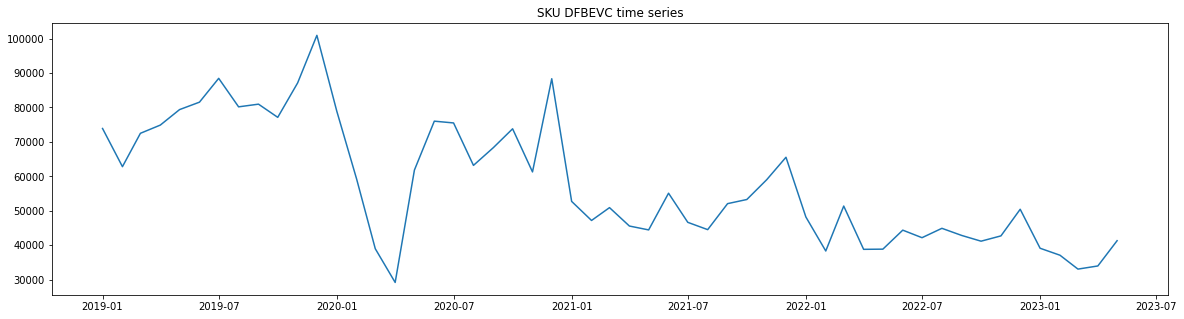

In [21]:
# function that grpahic the SKU in time series for Volume_Htls unified_sales_df_1_pivot_
def plot_time_series(data, sku):
    plt.figure(figsize=(20,5))
    plt.plot(data.loc[sku].index, data.loc[sku].values)
    plt.title(f'SKU {sku} time series')
    plt.show()

# plot the SKU 1
plot_time_series(unified_sales_df_1_pivot_, 'DFBEVC')

In [22]:
# study correlation for the Volume_Htls
corr = unified_sales_df_1.corr()
corr.style.background_gradient(cmap='coolwarm')


,Year,Month,Volume_Htls,GTO_LC,Promotional_Discount_LC,Other_Discounts_LC,Total_Discounts_LC,Excise_LC,Net_Revenue_LC,MACO_LC,VILC_LC,Retail_Sales_Index,Unemployment_Rate,CPI,Private_Consumption,Gross_Domestic_Saving,Brad_Money,GDP,Month_sin,Month_cos
Year,1.000000,-0.130075,0.057479,0.070924,-0.034844,-0.069795,-0.068363,-0.061231,0.073448,0.050203,0.122530,0.740945,-0.089088,0.913112,0.780965,-0.800885,0.973042,0.666030,0.121907,-0.078462
Month,-0.130075,1.000000,0.023568,0.024656,-0.001330,-0.011818,-0.009352,-0.020900,0.026806,0.027562,0.023061,0.092515,0.075573,0.043698,0.056080,0.079160,0.067743,0.055033,-0.776310,0.146867
Volume_Htls,0.057479,0.023568,1.000000,0.988702,-0.576802,-0.594608,-0.720151,-0.993641,0.984221,0.983609,0.913221,0.058794,-0.023084,0.063690,0.062416,-0.035914,0.061482,0.058657,-0.013460,0.019692
GTO_LC,0.070924,0.024656,0.988702,1.000000,-0.587826,-0.628221,-0.750239,-0.992927,0.997953,0.989330,0.944721,0.070025,-0.030175,0.080825,0.075660,-0.041713,0.075501,0.071556,-0.012690,0.023158
Promotional_Discount_LC,-0.034844,-0.001330,-0.576802,-0.587826,1.000000,0.307921,0.713368,0.576774,-0.564026,-0.563090,-0.524711,-0.036495,0.036906,-0.048268,-0.043542,0.000338,-0.029720,-0.047425,-0.012455,-0.006766
Other_Discounts_LC,-0.069795,-0.011818,-0.594608,-0.628221,0.307921,1.000000,0.886401,0.597546,-0.598880,-0.540509,-0.691632,-0.054171,0.020834,-0.084665,-0.059478,0.036823,-0.073785,-0.056369,0.022420,-0.004272
Total_Discounts_LC,-0.068363,-0.009352,-0.720151,-0.750239,0.713368,0.886401,1.000000,0.722293,-0.716998,-0.673709,-0.765703,-0.057658,0.033303,-0.085848,-0.064996,0.027288,-0.068809,-0.064596,0.010454,-0.006439
Excise_LC,-0.061231,-0.020900,-0.993641,-0.992927,0.576774,0.597546,0.722293,1.000000,-0.987726,-0.989968,-0.909778,-0.061990,0.026553,-0.068542,-0.066364,0.036377,-0.064927,-0.062820,0.011312,-0.020467
Net_Revenue_LC,0.073448,0.026806,0.984221,0.997953,-0.564026,-0.598880,-0.716998,-0.987726,1.000000,0.990754,0.948079,0.072657,-0.030531,0.083282,0.078463,-0.044148,0.078547,0.073932,-0.013265,0.024327
MACO_LC,0.050203,0.027562,0.983609,0.989330,-0.563090,-0.540509,-0.673709,-0.989968,0.990754,1.000000,0.896164,0.054483,-0.024874,0.058044,0.058854,-0.030153,0.055378,0.055931,-0.014522,0.023230


In [23]:
# select the correct features to predict the Volume_Htls with correlations
def select_features(corr, threshold):
    corr_abs = corr.abs()
    upper = corr_abs.where(np.triu(np.ones(corr_abs.shape), k=1).astype(np.bool))
    return [column for column in upper.columns if any(upper[column] > threshold)]

to_drop = select_features(corr, 0.8)
to_drop

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


['GTO_LC',
 'Total_Discounts_LC',
 'Excise_LC',
 'Net_Revenue_LC',
 'MACO_LC',
 'VILC_LC',
 'CPI',
 'Private_Consumption',
 'Gross_Domestic_Saving',
 'Brad_Money',
 'GDP']

In [24]:
# drop the features with to_drop
unified_sales_df_2 = unified_sales_df_1.drop(to_drop, axis=1)
unified_sales_df_2

,Year,Month,SKU,Brand,Pack,Size,Volume_Htls,Promotional_Discount_LC,Other_Discounts_LC,Retail_Sales_Index,Unemployment_Rate,Month_sin,Month_cos,date
1093,2019,1,ATPigG,XVgSwQ,gydWlH,StircS,26.92,0.000000e+00,-4.124374e+05,92.376274,10.856350,0.5,0.866025,2019-01-01
7272,2019,1,AjMMHY,ZVDcKH,GUbqnp,XotyGb,30.68,0.000000e+00,-5.970088e+06,92.376274,10.856350,0.5,0.866025,2019-01-01
4934,2019,1,AnHGGW,tcqKyp,gydWlH,StircS,-0.05,0.000000e+00,1.397059e+06,92.376274,10.856350,0.5,0.866025,2019-01-01
5567,2019,1,ArCILz,edvmUB,VmwBmS,pKILVK,0.44,0.000000e+00,0.000000e+00,92.376274,10.856350,0.5,0.866025,2019-01-01
2335,2019,1,BRTULv,LoYUOg,gydWlH,StircS,359.96,-1.498278e+06,-2.415699e+07,92.376274,10.856350,0.5,0.866025,2019-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,2023,7,ykzJnG,OmUaam,mmgsXK,CTOGzl,NaN,-7.013041e+05,-2.606652e+07,126.427720,12.247574,-0.5,-0.866025,2023-07-01
10720,2023,7,yoBrZu,wXKDHy,GUbqnp,StircS,NaN,0.000000e+00,-1.041767e+09,126.427720,12.247574,-0.5,-0.866025,2023-07-01
100,2023,7,yvlFSF,ZVDcKH,VmwBmS,pKILVK,NaN,-1.848855e+07,-1.535457e+06,126.427720,12.247574,-0.5,-0.866025,2023-07-01
10047,2023,7,zNJmaD,RHOCLL,mmgsXK,QgRfGP,NaN,-6.714036e+08,-2.931194e+08,126.427720,12.247574,-0.5,-0.866025,2023-07-01


In [25]:
unified_sales_df_2.Volume_Htls.isnull().sum()

284

In [26]:
# selecte from list_sku the SKU in unified_sales_df_2
unified_sales_df_2_ = unified_sales_df_2[unified_sales_df_2.SKU.isin(list_sku)]
unified_sales_df_2_

,Year,Month,SKU,Brand,Pack,Size,Volume_Htls,Promotional_Discount_LC,Other_Discounts_LC,Retail_Sales_Index,Unemployment_Rate,Month_sin,Month_cos,date
7272,2019,1,AjMMHY,ZVDcKH,GUbqnp,XotyGb,30.68,0.000000e+00,-5.970088e+06,92.376274,10.856350,0.5,0.866025,2019-01-01
5867,2019,1,CPXipv,ZfEWxz,GUbqnp,XotyGb,1311.54,0.000000e+00,-2.815863e+08,92.376274,10.856350,0.5,0.866025,2019-01-01
1749,2019,1,CpWPBT,erVQIv,GUbqnp,XotyGb,2460.59,0.000000e+00,-1.607505e+08,92.376274,10.856350,0.5,0.866025,2019-01-01
2137,2019,1,DFBEVC,oKraYa,mmgsXK,LnpBuL,73895.79,-2.684565e+09,-1.387911e+09,92.376274,10.856350,0.5,0.866025,2019-01-01
2900,2019,1,DGeaFa,ZVDcKH,GUbqnp,StircS,-1.19,0.000000e+00,-3.661198e+05,92.376274,10.856350,0.5,0.866025,2019-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6841,2023,7,yLPxju,FnpxCq,GUbqnp,StircS,NaN,0.000000e+00,0.000000e+00,126.427720,12.247574,-0.5,-0.866025,2023-07-01
7801,2023,7,yOnftl,FPgJHY,gydWlH,DNacAI,NaN,-4.181039e+07,-4.121545e+07,126.427720,12.247574,-0.5,-0.866025,2023-07-01
1489,2023,7,ykzJnG,OmUaam,mmgsXK,CTOGzl,NaN,-7.013041e+05,-2.606652e+07,126.427720,12.247574,-0.5,-0.866025,2023-07-01
100,2023,7,yvlFSF,ZVDcKH,VmwBmS,pKILVK,NaN,-1.848855e+07,-1.535457e+06,126.427720,12.247574,-0.5,-0.866025,2023-07-01


In [27]:
# filter unified_sales_df_2_ Volume_Htls not null and not 0
unified_sales_df_2_ = unified_sales_df_2_[unified_sales_df_2_.Volume_Htls.notnull()]
unified_sales_df_2_ = unified_sales_df_2_[unified_sales_df_2_.Volume_Htls != 0]
unified_sales_df_2_

,Year,Month,SKU,Brand,Pack,Size,Volume_Htls,Promotional_Discount_LC,Other_Discounts_LC,Retail_Sales_Index,Unemployment_Rate,Month_sin,Month_cos,date
7272,2019,1,AjMMHY,ZVDcKH,GUbqnp,XotyGb,30.68,0.000000e+00,-5.970088e+06,92.376274,10.856350,0.5,0.866025,2019-01-01
5867,2019,1,CPXipv,ZfEWxz,GUbqnp,XotyGb,1311.54,0.000000e+00,-2.815863e+08,92.376274,10.856350,0.5,0.866025,2019-01-01
1749,2019,1,CpWPBT,erVQIv,GUbqnp,XotyGb,2460.59,0.000000e+00,-1.607505e+08,92.376274,10.856350,0.5,0.866025,2019-01-01
2137,2019,1,DFBEVC,oKraYa,mmgsXK,LnpBuL,73895.79,-2.684565e+09,-1.387911e+09,92.376274,10.856350,0.5,0.866025,2019-01-01
2900,2019,1,DGeaFa,ZVDcKH,GUbqnp,StircS,-1.19,0.000000e+00,-3.661198e+05,92.376274,10.856350,0.5,0.866025,2019-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,2023,5,yEDccP,ddBknG,GUbqnp,StircS,7.83,0.000000e+00,-1.317728e+05,126.928690,11.872091,0.5,-0.866025,2023-05-01
7799,2023,5,yOnftl,FPgJHY,gydWlH,DNacAI,626.07,-3.988511e+07,-5.760560e+07,126.928690,11.872091,0.5,-0.866025,2023-05-01
1487,2023,5,ykzJnG,OmUaam,mmgsXK,CTOGzl,8681.15,0.000000e+00,-2.096756e+07,126.928690,11.872091,0.5,-0.866025,2023-05-01
98,2023,5,yvlFSF,ZVDcKH,VmwBmS,pKILVK,214.41,-2.594338e+06,-2.302083e+06,126.928690,11.872091,0.5,-0.866025,2023-05-01


In [28]:
# transform log the Volume_Htls and drop the Volume_Htls
unified_sales_df_2_['Volume_Htls_log'] = np.log(unified_sales_df_2_['Volume_Htls'])
unified_sales_df_2_=unified_sales_df_2_.drop('Volume_Htls', axis=1)
unified_sales_df_2_ = unified_sales_df_2_[unified_sales_df_2_.Volume_Htls_log.notnull()]
unified_sales_df_2_ = unified_sales_df_2_[unified_sales_df_2_.Volume_Htls_log != 0]
unified_sales_df_2_

invalid value encountered in log


,Year,Month,SKU,Brand,Pack,Size,Promotional_Discount_LC,Other_Discounts_LC,Retail_Sales_Index,Unemployment_Rate,Month_sin,Month_cos,date,Volume_Htls_log
7272,2019,1,AjMMHY,ZVDcKH,GUbqnp,XotyGb,0.000000e+00,-5.970088e+06,92.376274,10.856350,0.5,0.866025,2019-01-01,3.423611
5867,2019,1,CPXipv,ZfEWxz,GUbqnp,XotyGb,0.000000e+00,-2.815863e+08,92.376274,10.856350,0.5,0.866025,2019-01-01,7.178957
1749,2019,1,CpWPBT,erVQIv,GUbqnp,XotyGb,0.000000e+00,-1.607505e+08,92.376274,10.856350,0.5,0.866025,2019-01-01,7.808156
2137,2019,1,DFBEVC,oKraYa,mmgsXK,LnpBuL,-2.684565e+09,-1.387911e+09,92.376274,10.856350,0.5,0.866025,2019-01-01,11.210411
4774,2019,1,DvLfgO,aYZJQW,gydWlH,StircS,-1.606208e+06,-3.634189e+07,92.376274,10.856350,0.5,0.866025,2019-01-01,5.883935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,2023,5,yEDccP,ddBknG,GUbqnp,StircS,0.000000e+00,-1.317728e+05,126.928690,11.872091,0.5,-0.866025,2023-05-01,2.057963
7799,2023,5,yOnftl,FPgJHY,gydWlH,DNacAI,-3.988511e+07,-5.760560e+07,126.928690,11.872091,0.5,-0.866025,2023-05-01,6.439462
1487,2023,5,ykzJnG,OmUaam,mmgsXK,CTOGzl,0.000000e+00,-2.096756e+07,126.928690,11.872091,0.5,-0.866025,2023-05-01,9.068909
98,2023,5,yvlFSF,ZVDcKH,VmwBmS,pKILVK,-2.594338e+06,-2.302083e+06,126.928690,11.872091,0.5,-0.866025,2023-05-01,5.367890


In [29]:
unified_sales_df_2_

,Year,Month,SKU,Brand,Pack,Size,Promotional_Discount_LC,Other_Discounts_LC,Retail_Sales_Index,Unemployment_Rate,Month_sin,Month_cos,date,Volume_Htls_log
7272,2019,1,AjMMHY,ZVDcKH,GUbqnp,XotyGb,0.000000e+00,-5.970088e+06,92.376274,10.856350,0.5,0.866025,2019-01-01,3.423611
5867,2019,1,CPXipv,ZfEWxz,GUbqnp,XotyGb,0.000000e+00,-2.815863e+08,92.376274,10.856350,0.5,0.866025,2019-01-01,7.178957
1749,2019,1,CpWPBT,erVQIv,GUbqnp,XotyGb,0.000000e+00,-1.607505e+08,92.376274,10.856350,0.5,0.866025,2019-01-01,7.808156
2137,2019,1,DFBEVC,oKraYa,mmgsXK,LnpBuL,-2.684565e+09,-1.387911e+09,92.376274,10.856350,0.5,0.866025,2019-01-01,11.210411
4774,2019,1,DvLfgO,aYZJQW,gydWlH,StircS,-1.606208e+06,-3.634189e+07,92.376274,10.856350,0.5,0.866025,2019-01-01,5.883935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264,2023,5,yEDccP,ddBknG,GUbqnp,StircS,0.000000e+00,-1.317728e+05,126.928690,11.872091,0.5,-0.866025,2023-05-01,2.057963
7799,2023,5,yOnftl,FPgJHY,gydWlH,DNacAI,-3.988511e+07,-5.760560e+07,126.928690,11.872091,0.5,-0.866025,2023-05-01,6.439462
1487,2023,5,ykzJnG,OmUaam,mmgsXK,CTOGzl,0.000000e+00,-2.096756e+07,126.928690,11.872091,0.5,-0.866025,2023-05-01,9.068909
98,2023,5,yvlFSF,ZVDcKH,VmwBmS,pKILVK,-2.594338e+06,-2.302083e+06,126.928690,11.872091,0.5,-0.866025,2023-05-01,5.367890


In [30]:
### Make a table constraints
table= unified_sales_df_2_.drop_duplicates(subset=['SKU', 
'Brand', 'Pack','Size','Month'], keep='last')[['SKU', 'Brand', 'Pack','Size','Month']]

# drop Year in max_discount_const_brand, max_discount_const_pack and max_discount_const_price_segment
max_discount_const_brand = max_discount_const_brand.drop('Year', axis=1)
# rename the column max_discount to max_discount_brand
max_discount_const_brand= max_discount_const_brand.rename(columns={'max_discount': 'Max_Discount_Brand'})
#max_discount_const_pack = max_discount_const_pack.drop('Year', axis=1)
# rename the column max_discount to max_discount_pack
max_discount_const_pack= max_discount_const_pack.rename(columns={'max_discount': 'Max_Discount_Pack'})
Max_discount_const_price_segment = max_discount_const_price_segment.drop('Year', axis=1)
# merge table with max_discount_const_brand
table = table.merge(max_discount_const_brand, how='left', on=['Brand','Month'])
# merge table with max_discount_const_pack
table = table.merge(max_discount_const_pack, how='left', on=['Pack','Month'])
# merge table with Max_discount_const_price_segment

# only filter the table that have in the Month=[6,7]
table = table[table.Month.isin([6,7])]
table

,SKU,Brand,Pack,Size,Month,Max_Discount_Brand,Year,Max_Discount_Pack
5,GUtBWz,OmUaam,GUbqnp,drgWuE,6,-1.006541e+10,2023.0,-3.830511e+10
6,IUbuVR,XVgSwQ,GUbqnp,drgWuE,6,-2.325060e+09,2023.0,-3.830511e+10
7,GUtBWz,OmUaam,GUbqnp,drgWuE,7,-9.669847e+09,2023.0,-3.824104e+10
8,IUbuVR,XVgSwQ,GUbqnp,drgWuE,7,-2.347878e+09,2023.0,-3.824104e+10
9,OfEVkh,vjtstb,gydWlH,grgpWE,7,NaN,2023.0,-1.306834e+10
...,...,...,...,...,...,...,...,...
449,yEDccP,ddBknG,GUbqnp,StircS,7,-8.134735e+08,2023.0,-3.824104e+10
450,yOnftl,FPgJHY,GUbqnp,WxSZYN,7,-2.494979e+08,2023.0,-3.824104e+10
451,ykzJnG,OmUaam,mmgsXK,CTOGzl,7,-9.669847e+09,2023.0,-1.336721e+10
452,yvlFSF,ZVDcKH,VmwBmS,pKILVK,7,-4.713137e+09,2023.0,-3.855361e+07


In [31]:
# integrating PriceSegment in table
table = table.merge(brand_price_segment, how='left', on=['Brand'])
# integrating max_discount_const_price_segment
# rename max_discount to Max_Discount_Price_Segment in max_discount_const_price_segment
max_discount_const_price_segment = max_discount_const_price_segment.rename(columns={'max_discount': 'Max_Discount_Price_Segment'})
max_discount_const_price_segment= max_discount_const_price_segment.drop('Year', axis=1)
# merge table with Max_discount_const_price_segment
table = table.merge(max_discount_const_price_segment, how='left', on=['PriceSegment','Month'])
table


,SKU,Brand,Pack,Size,Month,Max_Discount_Brand,Year,Max_Discount_Pack,PriceSegment,Max_Discount_Price_Segment
0,GUtBWz,OmUaam,GUbqnp,drgWuE,6,-1.006541e+10,2023.0,-3.830511e+10,zLdfYx,-3.566363e+10
1,IUbuVR,XVgSwQ,GUbqnp,drgWuE,6,-2.325060e+09,2023.0,-3.830511e+10,zLdfYx,-3.566363e+10
2,GUtBWz,OmUaam,GUbqnp,drgWuE,7,-9.669847e+09,2023.0,-3.824104e+10,zLdfYx,-3.560526e+10
3,IUbuVR,XVgSwQ,GUbqnp,drgWuE,7,-2.347878e+09,2023.0,-3.824104e+10,zLdfYx,-3.560526e+10
4,OfEVkh,vjtstb,gydWlH,grgpWE,7,NaN,2023.0,-1.306834e+10,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
170,yEDccP,ddBknG,GUbqnp,StircS,7,-8.134735e+08,2023.0,-3.824104e+10,qtUPAJ,-4.535993e+09
171,yOnftl,FPgJHY,GUbqnp,WxSZYN,7,-2.494979e+08,2023.0,-3.824104e+10,rBvOre,-1.569308e+10
172,ykzJnG,OmUaam,mmgsXK,CTOGzl,7,-9.669847e+09,2023.0,-1.336721e+10,zLdfYx,-3.560526e+10
173,yvlFSF,ZVDcKH,VmwBmS,pKILVK,7,-4.713137e+09,2023.0,-3.855361e+07,FkcKlo,-7.727772e+09


In [32]:
table_6 = table[table.Month == 6]
# rename Max_Discount_Brand to Max_Discount_Brand_6 and Max_Discount_Pack to Max_Discount_Pack_6
table_6 = table_6.rename(columns={'Max_Discount_Brand': 'Max_Discount_Brand_6', 'Max_Discount_Pack': 'Max_Discount_Pack_6',
'Max_Discount_Price_Segment': 'Max_Discount_Price_Segment_6'})
# drop Month
table_6 = table_6.drop('Month', axis=1)
table_6

,SKU,Brand,Pack,Size,Max_Discount_Brand_6,Year,Max_Discount_Pack_6,PriceSegment,Max_Discount_Price_Segment_6
0,GUtBWz,OmUaam,GUbqnp,drgWuE,-1.006541e+10,2023.0,-3.830511e+10,zLdfYx,-3.566363e+10
1,IUbuVR,XVgSwQ,GUbqnp,drgWuE,-2.325060e+09,2023.0,-3.830511e+10,zLdfYx,-3.566363e+10
5,HUkyVk,XVgSwQ,GUbqnp,WxSZYN,-2.325060e+09,2023.0,-3.830511e+10,zLdfYx,-3.566363e+10
6,ZdjpIJ,LoYUOg,GUbqnp,StircS,-2.792598e+08,2023.0,-3.830511e+10,FkcKlo,-7.075328e+09
8,CpWPBT,erVQIv,GUbqnp,XotyGb,NaN,2023.0,-3.830511e+10,NaN,NaN
...,...,...,...,...,...,...,...,...,...
105,yEDccP,ddBknG,GUbqnp,StircS,-8.135884e+08,2023.0,-3.830511e+10,qtUPAJ,-4.217010e+09
106,yOnftl,FPgJHY,GUbqnp,WxSZYN,-2.340258e+08,2023.0,-3.830511e+10,rBvOre,-1.402168e+10
107,ykzJnG,OmUaam,mmgsXK,CTOGzl,-1.006541e+10,2023.0,-1.313038e+10,zLdfYx,-3.566363e+10
108,yvlFSF,ZVDcKH,VmwBmS,pKILVK,-4.362497e+09,2023.0,-4.456805e+07,FkcKlo,-7.075328e+09


In [33]:
table_7 = table[table.Month == 7]
# rename Max_Discount_Brand to Max_Discount_Brand_6 and Max_Discount_Pack to Max_Discount_Pack_6
table_7 = table_7.rename(columns={'Max_Discount_Brand': 'Max_Discount_Brand_7', 'Max_Discount_Pack': 'Max_Discount_Pack_7','Max_Discount_Price_Segment': 'Max_Discount_Price_Segment_7'})
# drop Month
table_7 = table_7.drop('Month', axis=1)
table_7

,SKU,Brand,Pack,Size,Max_Discount_Brand_7,Year,Max_Discount_Pack_7,PriceSegment,Max_Discount_Price_Segment_7
2,GUtBWz,OmUaam,GUbqnp,drgWuE,-9.669847e+09,2023.0,-3.824104e+10,zLdfYx,-3.560526e+10
3,IUbuVR,XVgSwQ,GUbqnp,drgWuE,-2.347878e+09,2023.0,-3.824104e+10,zLdfYx,-3.560526e+10
4,OfEVkh,vjtstb,gydWlH,grgpWE,NaN,2023.0,-1.306834e+10,NaN,NaN
7,tCzvNv,vjtstb,gydWlH,WxSZYN,NaN,2023.0,-1.306834e+10,NaN,NaN
28,CpWPBT,erVQIv,GUbqnp,XotyGb,NaN,2023.0,-3.824104e+10,NaN,NaN
...,...,...,...,...,...,...,...,...,...
170,yEDccP,ddBknG,GUbqnp,StircS,-8.134735e+08,2023.0,-3.824104e+10,qtUPAJ,-4.535993e+09
171,yOnftl,FPgJHY,GUbqnp,WxSZYN,-2.494979e+08,2023.0,-3.824104e+10,rBvOre,-1.569308e+10
172,ykzJnG,OmUaam,mmgsXK,CTOGzl,-9.669847e+09,2023.0,-1.336721e+10,zLdfYx,-3.560526e+10
173,yvlFSF,ZVDcKH,VmwBmS,pKILVK,-4.713137e+09,2023.0,-3.855361e+07,FkcKlo,-7.727772e+09


In [34]:
# merge table_6 with table_7 how left on SKU, Brand, Pack, Size
table = table_6.merge(table_7, how='left', on=['SKU', 'Brand', 'Pack', 'Size'])
table

,SKU,Brand,Pack,Size,Max_Discount_Brand_6,Year_x,Max_Discount_Pack_6,PriceSegment_x,Max_Discount_Price_Segment_6,Max_Discount_Brand_7,Year_y,Max_Discount_Pack_7,PriceSegment_y,Max_Discount_Price_Segment_7
0,GUtBWz,OmUaam,GUbqnp,drgWuE,-1.006541e+10,2023.0,-3.830511e+10,zLdfYx,-3.566363e+10,-9.669847e+09,2023.0,-3.824104e+10,zLdfYx,-3.560526e+10
1,IUbuVR,XVgSwQ,GUbqnp,drgWuE,-2.325060e+09,2023.0,-3.830511e+10,zLdfYx,-3.566363e+10,-2.347878e+09,2023.0,-3.824104e+10,zLdfYx,-3.560526e+10
2,HUkyVk,XVgSwQ,GUbqnp,WxSZYN,-2.325060e+09,2023.0,-3.830511e+10,zLdfYx,-3.566363e+10,-2.347878e+09,2023.0,-3.824104e+10,zLdfYx,-3.560526e+10
3,ZdjpIJ,LoYUOg,GUbqnp,StircS,-2.792598e+08,2023.0,-3.830511e+10,FkcKlo,-7.075328e+09,-2.675090e+08,2023.0,-3.824104e+10,FkcKlo,-7.727772e+09
4,CpWPBT,erVQIv,GUbqnp,XotyGb,NaN,2023.0,-3.830511e+10,NaN,NaN,NaN,2023.0,-3.824104e+10,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,yEDccP,ddBknG,GUbqnp,StircS,-8.135884e+08,2023.0,-3.830511e+10,qtUPAJ,-4.217010e+09,-8.134735e+08,2023.0,-3.824104e+10,qtUPAJ,-4.535993e+09
84,yOnftl,FPgJHY,GUbqnp,WxSZYN,-2.340258e+08,2023.0,-3.830511e+10,rBvOre,-1.402168e+10,-2.494979e+08,2023.0,-3.824104e+10,rBvOre,-1.569308e+10
85,ykzJnG,OmUaam,mmgsXK,CTOGzl,-1.006541e+10,2023.0,-1.313038e+10,zLdfYx,-3.566363e+10,-9.669847e+09,2023.0,-1.336721e+10,zLdfYx,-3.560526e+10
86,yvlFSF,ZVDcKH,VmwBmS,pKILVK,-4.362497e+09,2023.0,-4.456805e+07,FkcKlo,-7.075328e+09,-4.713137e+09,2023.0,-3.855361e+07,FkcKlo,-7.727772e+09


In [35]:
# drop PriceSegment_x and rename PriceSegment_y
table = table.drop('PriceSegment_x', axis=1)
table = table.rename(columns={'PriceSegment_y': 'PriceSegment'})
table

,SKU,Brand,Pack,Size,Max_Discount_Brand_6,Year_x,Max_Discount_Pack_6,Max_Discount_Price_Segment_6,Max_Discount_Brand_7,Year_y,Max_Discount_Pack_7,PriceSegment,Max_Discount_Price_Segment_7
0,GUtBWz,OmUaam,GUbqnp,drgWuE,-1.006541e+10,2023.0,-3.830511e+10,-3.566363e+10,-9.669847e+09,2023.0,-3.824104e+10,zLdfYx,-3.560526e+10
1,IUbuVR,XVgSwQ,GUbqnp,drgWuE,-2.325060e+09,2023.0,-3.830511e+10,-3.566363e+10,-2.347878e+09,2023.0,-3.824104e+10,zLdfYx,-3.560526e+10
2,HUkyVk,XVgSwQ,GUbqnp,WxSZYN,-2.325060e+09,2023.0,-3.830511e+10,-3.566363e+10,-2.347878e+09,2023.0,-3.824104e+10,zLdfYx,-3.560526e+10
3,ZdjpIJ,LoYUOg,GUbqnp,StircS,-2.792598e+08,2023.0,-3.830511e+10,-7.075328e+09,-2.675090e+08,2023.0,-3.824104e+10,FkcKlo,-7.727772e+09
4,CpWPBT,erVQIv,GUbqnp,XotyGb,NaN,2023.0,-3.830511e+10,NaN,NaN,2023.0,-3.824104e+10,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,yEDccP,ddBknG,GUbqnp,StircS,-8.135884e+08,2023.0,-3.830511e+10,-4.217010e+09,-8.134735e+08,2023.0,-3.824104e+10,qtUPAJ,-4.535993e+09
84,yOnftl,FPgJHY,GUbqnp,WxSZYN,-2.340258e+08,2023.0,-3.830511e+10,-1.402168e+10,-2.494979e+08,2023.0,-3.824104e+10,rBvOre,-1.569308e+10
85,ykzJnG,OmUaam,mmgsXK,CTOGzl,-1.006541e+10,2023.0,-1.313038e+10,-3.566363e+10,-9.669847e+09,2023.0,-1.336721e+10,zLdfYx,-3.560526e+10
86,yvlFSF,ZVDcKH,VmwBmS,pKILVK,-4.362497e+09,2023.0,-4.456805e+07,-7.075328e+09,-4.713137e+09,2023.0,-3.855361e+07,FkcKlo,-7.727772e+09


In [36]:
# merge table with unified_sales_df_2_ how left on SKU, Brand, Pack, Size
unified_sales_df_2_ = unified_sales_df_2_.merge(table, how='left', on=['SKU', 'Brand', 'Pack', 'Size'])
unified_sales_df_2_

,Year,Month,SKU,Brand,Pack,Size,Promotional_Discount_LC,Other_Discounts_LC,Retail_Sales_Index,Unemployment_Rate,Month_sin,Month_cos,date,Volume_Htls_log,Max_Discount_Brand_6,Year_x,Max_Discount_Pack_6,Max_Discount_Price_Segment_6,Max_Discount_Brand_7,Year_y,Max_Discount_Pack_7,PriceSegment,Max_Discount_Price_Segment_7
0,2019,1,AjMMHY,ZVDcKH,GUbqnp,XotyGb,0.000000e+00,-5.970088e+06,92.376274,10.856350,0.5,0.866025,2019-01-01,3.423611,-4.362497e+09,2023.0,-3.830511e+10,-7.075328e+09,-4.713137e+09,2023.0,-3.824104e+10,FkcKlo,-7.727772e+09
1,2019,1,CPXipv,ZfEWxz,GUbqnp,XotyGb,0.000000e+00,-2.815863e+08,92.376274,10.856350,0.5,0.866025,2019-01-01,7.178957,-3.397813e+09,2023.0,-3.830511e+10,-1.402168e+10,-3.685043e+09,2023.0,-3.824104e+10,rBvOre,-1.569308e+10
2,2019,1,CpWPBT,erVQIv,GUbqnp,XotyGb,0.000000e+00,-1.607505e+08,92.376274,10.856350,0.5,0.866025,2019-01-01,7.808156,NaN,2023.0,-3.830511e+10,NaN,NaN,2023.0,-3.824104e+10,NaN,NaN
3,2019,1,DFBEVC,oKraYa,mmgsXK,LnpBuL,-2.684565e+09,-1.387911e+09,92.376274,10.856350,0.5,0.866025,2019-01-01,11.210411,-1.189053e+10,2023.0,-1.313038e+10,-3.566363e+10,-1.289685e+10,2023.0,-1.336721e+10,zLdfYx,-3.560526e+10
4,2019,1,DvLfgO,aYZJQW,gydWlH,StircS,-1.606208e+06,-3.634189e+07,92.376274,10.856350,0.5,0.866025,2019-01-01,5.883935,-8.108785e+07,2023.0,-1.185722e+10,-1.402168e+10,-8.325367e+07,2023.0,-1.306834e+10,rBvOre,-1.569308e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3818,2023,5,yEDccP,ddBknG,GUbqnp,StircS,0.000000e+00,-1.317728e+05,126.928690,11.872091,0.5,-0.866025,2023-05-01,2.057963,-8.135884e+08,2023.0,-3.830511e+10,-4.217010e+09,-8.134735e+08,2023.0,-3.824104e+10,qtUPAJ,-4.535993e+09
3819,2023,5,yOnftl,FPgJHY,gydWlH,DNacAI,-3.988511e+07,-5.760560e+07,126.928690,11.872091,0.5,-0.866025,2023-05-01,6.439462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3820,2023,5,ykzJnG,OmUaam,mmgsXK,CTOGzl,0.000000e+00,-2.096756e+07,126.928690,11.872091,0.5,-0.866025,2023-05-01,9.068909,-1.006541e+10,2023.0,-1.313038e+10,-3.566363e+10,-9.669847e+09,2023.0,-1.336721e+10,zLdfYx,-3.560526e+10
3821,2023,5,yvlFSF,ZVDcKH,VmwBmS,pKILVK,-2.594338e+06,-2.302083e+06,126.928690,11.872091,0.5,-0.866025,2023-05-01,5.367890,-4.362497e+09,2023.0,-4.456805e+07,-7.075328e+09,-4.713137e+09,2023.0,-3.855361e+07,FkcKlo,-7.727772e+09


#### Starting problem of Regression in order to found VOL and NR

In [37]:
# select the last month available of each SKU - Brand - Pack  to have the pred_data
# firstable sort by date 
unified_sales_df_2_["date"] = pd.to_datetime(unified_sales_df_2_[["Year", "Month"]].assign(DAY=1))
# sort by date
unified_sales_df_2_=unified_sales_df_2_.sort_values(by=['date', 'SKU'])
pred_data = unified_sales_df_2_.groupby(['SKU', 'Brand', 'Pack']).last().reset_index()
# drop date
pred_data = pred_data.drop('date', axis=1)
pred_data=pred_data[['Year','Month'	,'SKU'	,'Brand'	,'Pack',	'Size',	'Promotional_Discount_LC'	,'Other_Discounts_LC'	,'Retail_Sales_Index'	,'Unemployment_Rate'	,'Month_sin'	,'Month_cos'	,'Volume_Htls_log','Max_Discount_Brand_6',	'Max_Discount_Pack_6',	'Max_Discount_Brand_7','PriceSegment','Max_Discount_Price_Segment_7','Max_Discount_Price_Segment_6','Max_Discount_Pack_7']]
pred_data

,Year,Month,SKU,Brand,Pack,Size,Promotional_Discount_LC,Other_Discounts_LC,Retail_Sales_Index,Unemployment_Rate,Month_sin,Month_cos,Volume_Htls_log,Max_Discount_Brand_6,Max_Discount_Pack_6,Max_Discount_Brand_7,PriceSegment,Max_Discount_Price_Segment_7,Max_Discount_Price_Segment_6,Max_Discount_Pack_7
0,2023,5,AjMMHY,ZVDcKH,GUbqnp,XotyGb,0.000000e+00,-7.058306e+08,126.92869,11.872091,5.000000e-01,-0.866025,8.301857,-4.362497e+09,-3.830511e+10,-4.713137e+09,FkcKlo,-7.727772e+09,-7.075328e+09,-3.824104e+10
1,2023,5,CPXipv,ZfEWxz,GUbqnp,XotyGb,-2.007783e+07,-6.553083e+07,126.92869,11.872091,5.000000e-01,-0.866025,6.407787,-3.397813e+09,-3.830511e+10,-3.685043e+09,rBvOre,-1.569308e+10,-1.402168e+10,-3.824104e+10
2,2023,5,CpWPBT,YDEkWq,GUbqnp,XotyGb,0.000000e+00,-1.555859e+07,126.92869,11.872091,5.000000e-01,-0.866025,5.930812,NaN,NaN,NaN,None,NaN,NaN,NaN
3,2022,1,CpWPBT,erVQIv,GUbqnp,XotyGb,0.000000e+00,-4.907147e+05,119.32861,12.153896,5.000000e-01,0.866025,0.524729,NaN,-3.830511e+10,NaN,None,NaN,NaN,-3.824104e+10
4,2023,5,DFBEVC,oKraYa,mmgsXK,LnpBuL,-8.972409e+08,-2.387932e+08,126.92869,11.872091,5.000000e-01,-0.866025,10.628668,-1.189053e+10,-1.313038e+10,-1.289685e+10,zLdfYx,-3.560526e+10,-3.566363e+10,-1.336721e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,2022,12,yOnftl,FPgJHY,GUbqnp,WxSZYN,-1.326057e+08,-1.225896e+08,120.59457,11.117676,-2.449294e-16,1.000000,7.757457,-2.340258e+08,-3.830511e+10,-2.494979e+08,rBvOre,-1.569308e+10,-1.402168e+10,-3.824104e+10
91,2023,5,yOnftl,FPgJHY,gydWlH,DNacAI,-3.988511e+07,-5.760560e+07,126.92869,11.872091,5.000000e-01,-0.866025,6.439462,NaN,NaN,NaN,None,NaN,NaN,NaN
92,2023,5,ykzJnG,OmUaam,mmgsXK,CTOGzl,0.000000e+00,-2.096756e+07,126.92869,11.872091,5.000000e-01,-0.866025,9.068909,-1.006541e+10,-1.313038e+10,-9.669847e+09,zLdfYx,-3.560526e+10,-3.566363e+10,-1.336721e+10
93,2023,5,yvlFSF,ZVDcKH,VmwBmS,pKILVK,-2.594338e+06,-2.302083e+06,126.92869,11.872091,5.000000e-01,-0.866025,5.367890,-4.362497e+09,-4.456805e+07,-4.713137e+09,FkcKlo,-7.727772e+09,-7.075328e+09,-3.855361e+07


In [38]:
train_data = unified_sales_df_2_.groupby(['SKU', 'Brand', 'Pack']).apply(lambda x: x.iloc[:-1]).reset_index(drop=True)
# drop date
train_data = train_data.drop('date', axis=1)
train_data

,Year,Month,SKU,Brand,Pack,Size,Promotional_Discount_LC,Other_Discounts_LC,Retail_Sales_Index,Unemployment_Rate,Month_sin,Month_cos,Volume_Htls_log,Max_Discount_Brand_6,Year_x,Max_Discount_Pack_6,Max_Discount_Price_Segment_6,Max_Discount_Brand_7,Year_y,Max_Discount_Pack_7,PriceSegment,Max_Discount_Price_Segment_7
0,2019,1,AjMMHY,ZVDcKH,GUbqnp,XotyGb,0.000000e+00,-5.970088e+06,92.376274,10.856350,5.000000e-01,8.660254e-01,3.423611,-4.362497e+09,2023.0,-3.830511e+10,-7.075328e+09,-4.713137e+09,2023.0,-3.824104e+10,FkcKlo,-7.727772e+09
1,2019,2,AjMMHY,ZVDcKH,GUbqnp,XotyGb,0.000000e+00,-8.045901e+06,96.299010,10.856350,8.660254e-01,5.000000e-01,4.037421,-4.362497e+09,2023.0,-3.830511e+10,-7.075328e+09,-4.713137e+09,2023.0,-3.824104e+10,FkcKlo,-7.727772e+09
2,2019,3,AjMMHY,ZVDcKH,GUbqnp,XotyGb,-1.565903e+04,-6.105504e+06,96.791115,10.856350,1.000000e+00,6.123234e-17,4.242765,-4.362497e+09,2023.0,-3.830511e+10,-7.075328e+09,-4.713137e+09,2023.0,-3.824104e+10,FkcKlo,-7.727772e+09
3,2019,4,AjMMHY,ZVDcKH,GUbqnp,XotyGb,-6.706383e+04,-7.800648e+06,101.030220,10.408203,8.660254e-01,-5.000000e-01,4.403299,-4.362497e+09,2023.0,-3.830511e+10,-7.075328e+09,-4.713137e+09,2023.0,-3.824104e+10,FkcKlo,-7.727772e+09
4,2019,5,AjMMHY,ZVDcKH,GUbqnp,XotyGb,-2.859477e+04,-3.336349e+06,103.469270,10.408203,5.000000e-01,-8.660254e-01,3.725934,-4.362497e+09,2023.0,-3.830511e+10,-7.075328e+09,-4.713137e+09,2023.0,-3.824104e+10,FkcKlo,-7.727772e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3723,2022,12,ztGEho,oKraYa,GUbqnp,drgWuE,-3.574111e+06,-2.039960e+07,120.594570,11.117676,-2.449294e-16,1.000000e+00,6.479262,-1.189053e+10,2023.0,-3.830511e+10,-3.566363e+10,-1.289685e+10,2023.0,-3.824104e+10,zLdfYx,-3.560526e+10
3724,2023,1,ztGEho,oKraYa,GUbqnp,drgWuE,-3.991876e+07,6.310950e+06,123.191780,10.748787,5.000000e-01,8.660254e-01,6.417467,-1.189053e+10,2023.0,-3.830511e+10,-3.566363e+10,-1.289685e+10,2023.0,-3.824104e+10,zLdfYx,-3.560526e+10
3725,2023,2,ztGEho,oKraYa,GUbqnp,drgWuE,-3.430825e+08,-5.784408e+07,123.458660,10.748787,8.660254e-01,5.000000e-01,8.901187,-1.189053e+10,2023.0,-3.830511e+10,-3.566363e+10,-1.289685e+10,2023.0,-3.824104e+10,zLdfYx,-3.560526e+10
3726,2023,3,ztGEho,oKraYa,GUbqnp,drgWuE,-2.110312e+08,-2.525724e+08,119.802900,10.748787,1.000000e+00,6.123234e-17,8.524437,-1.189053e+10,2023.0,-3.830511e+10,-3.566363e+10,-1.289685e+10,2023.0,-3.824104e+10,zLdfYx,-3.560526e+10


In [39]:
# encode the categorical features
# function to encode the categorical features
def encode_categorical_features(data, categorical_features):
    pipe = make_pipeline(OneHotEncoder(handle_unknown='ignore'))
    pipe.fit(data[categorical_features])
    return pipe

# function to scale the numerical features
def scale_numerical_features(data, numerical_features):
    pipe = make_pipeline(StandardScaler())
    pipe.fit(data[numerical_features])
    return pipe

# function to make the column transformer
def make_column_transformer(categorical_features, numerical_features):

    return make_column_transformer(
        (encode_categorical_features(categorical_features), categorical_features),
    )

In [40]:
categorical_features = ['SKU', 'Brand', 'Size','Pack','PriceSegment']

In [41]:
from sklearn.preprocessing import LabelEncoder

def encode_categorical_features(data, categorical_columns):
    data_encoded = data.copy()
    label_encoders = {}
    
    for column in categorical_columns:
        label_encoder = LabelEncoder()
        data_encoded[column] = label_encoder.fit_transform(data[column])
        label_encoders[column] = label_encoder
    
    return data_encoded, label_encoders


def decode_categorical_features(data, categorical_columns, label_encoders):
    data_decoded = data.copy()
    
    for column in categorical_columns:
        label_encoder = label_encoders[column]
        data_decoded[column] = label_encoder.inverse_transform(data[column])
    
    return data_decoded

def decode_categorical_features_col(data, column, label_encoders):
    data_decoded = data.copy()
    
    label_encoder = label_encoders[column]

    # print(label_encoders[column], column)

    data_decoded[column] = label_encoder.inverse_transform(data[column].astype(int))
    
    return data_decoded


In [42]:
train_data_encoded, label_encoders = encode_categorical_features(train_data, categorical_features)
test_data_encoded , label_encoders= encode_categorical_features(pred_data, categorical_features)

In [43]:
# # Decoder prepare
train_data_decoded = decode_categorical_features(train_data_encoded,categorical_features, label_encoders)
test_data_decoded = decode_categorical_features(test_data_encoded, categorical_features,label_encoders)

In [44]:
train_data_encoded.isnull().sum()

Year                              0
Month                             0
SKU                               0
Brand                             0
Pack                              0
Size                              0
Promotional_Discount_LC           0
Other_Discounts_LC                0
Retail_Sales_Index                0
Unemployment_Rate                 0
Month_sin                         0
Month_cos                         0
Volume_Htls_log                   0
Max_Discount_Brand_6            364
Year_x                           26
Max_Discount_Pack_6              26
Max_Discount_Price_Segment_6    364
Max_Discount_Brand_7            370
Year_y                           32
Max_Discount_Pack_7              32
PriceSegment                      0
Max_Discount_Price_Segment_7    370
dtype: int64

In [45]:
constraints_table=pd.concat([train_data_encoded, test_data_encoded], axis=0)
constraints_table=constraints_table.drop_duplicates(subset=['SKU', 'Brand', 'Pack','Size'], keep='last')
constraints_table=constraints_table[['SKU', 'Brand', 'Pack','Size','Max_Discount_Brand_6',	'Max_Discount_Pack_6',	'Max_Discount_Brand_7',	'Max_Discount_Pack_7', 'Max_Discount_Price_Segment_6', 'Max_Discount_Price_Segment_7']]
constraints_table

,SKU,Brand,Pack,Size,Max_Discount_Brand_6,Max_Discount_Pack_6,Max_Discount_Brand_7,Max_Discount_Pack_7,Max_Discount_Price_Segment_6,Max_Discount_Price_Segment_7
48,0,10,0,9,-4.362497e+09,-3.830511e+10,-4.713137e+09,-3.824104e+10,-7.075328e+09,-7.727772e+09
100,1,13,0,9,-3.397813e+09,-3.830511e+10,-3.685043e+09,-3.824104e+10,-1.402168e+10,-1.569308e+10
135,2,18,0,9,NaN,-3.830511e+10,NaN,-3.824104e+10,NaN,NaN
187,3,20,3,4,-1.189053e+10,-1.313038e+10,-1.289685e+10,-1.336721e+10,-3.566363e+10,-3.560526e+10
235,4,10,0,6,-4.362497e+09,-3.830511e+10,-4.713137e+09,-3.824104e+10,-7.075328e+09,-7.727772e+09
...,...,...,...,...,...,...,...,...,...,...
90,82,1,0,8,-2.340258e+08,-3.830511e+10,-2.494979e+08,-3.824104e+10,-1.402168e+10,-1.569308e+10
91,82,1,2,1,NaN,NaN,NaN,NaN,NaN,NaN
92,83,5,3,0,-1.006541e+10,-1.313038e+10,-9.669847e+09,-1.336721e+10,-3.566363e+10,-3.560526e+10
93,84,11,1,13,-4.362497e+09,-4.456805e+07,-4.713137e+09,-3.855361e+07,-7.075328e+09,-7.727772e+09


In [46]:
# drop the Max_Discount_Brand_6, Max_Discount_Pack_6, Max_Discount_Brand_7, Max_Discount_Pack_7 in train_data_encoded and test_data_encoded
train_data_encoded = train_data_encoded.drop(['Max_Discount_Brand_6',	'Max_Discount_Pack_6',	'Max_Discount_Brand_7',	'Max_Discount_Pack_7','Max_Discount_Price_Segment_6','Max_Discount_Price_Segment_7','Year_x','Year_y'], axis=1)
test_data_encoded = test_data_encoded.drop(['Max_Discount_Brand_6',	'Max_Discount_Pack_6',	'Max_Discount_Brand_7',	'Max_Discount_Pack_7','Max_Discount_Price_Segment_6','Max_Discount_Price_Segment_7'], axis=1)


In [47]:
train_data_encoded

,Year,Month,SKU,Brand,Pack,Size,Promotional_Discount_LC,Other_Discounts_LC,Retail_Sales_Index,Unemployment_Rate,Month_sin,Month_cos,Volume_Htls_log,PriceSegment
0,2019,1,0,10,0,9,0.000000e+00,-5.970088e+06,92.376274,10.856350,5.000000e-01,8.660254e-01,3.423611,0
1,2019,2,0,10,0,9,0.000000e+00,-8.045901e+06,96.299010,10.856350,8.660254e-01,5.000000e-01,4.037421,0
2,2019,3,0,10,0,9,-1.565903e+04,-6.105504e+06,96.791115,10.856350,1.000000e+00,6.123234e-17,4.242765,0
3,2019,4,0,10,0,9,-6.706383e+04,-7.800648e+06,101.030220,10.408203,8.660254e-01,-5.000000e-01,4.403299,0
4,2019,5,0,10,0,9,-2.859477e+04,-3.336349e+06,103.469270,10.408203,5.000000e-01,-8.660254e-01,3.725934,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3723,2022,12,85,20,0,10,-3.574111e+06,-2.039960e+07,120.594570,11.117676,-2.449294e-16,1.000000e+00,6.479262,3
3724,2023,1,85,20,0,10,-3.991876e+07,6.310950e+06,123.191780,10.748787,5.000000e-01,8.660254e-01,6.417467,3
3725,2023,2,85,20,0,10,-3.430825e+08,-5.784408e+07,123.458660,10.748787,8.660254e-01,5.000000e-01,8.901187,3
3726,2023,3,85,20,0,10,-2.110312e+08,-2.525724e+08,119.802900,10.748787,1.000000e+00,6.123234e-17,8.524437,3


In [48]:
# split the data_encoded in train and test and validation
train, test = train_test_split(train_data_encoded, test_size=0.2, random_state=42)
train, val = train_test_split(train, test_size=0.2, random_state=42)

X_train = train.drop('Volume_Htls_log', axis=1)
y_train = train['Volume_Htls_log']
X_val = val.drop('Volume_Htls_log', axis=1)
y_val = val['Volume_Htls_log']
X_test = test.drop('Volume_Htls_log', axis=1)
y_test = test['Volume_Htls_log']

In [49]:
print(f"Size {X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape}")

Size ((2385, 13), (2385,), (597, 13), (597,), (746, 13), (746,))


In [50]:
# check infinities in the X_train, X_val and X_test, y_train, y_val and y_test
np.isinf(X_train).sum().sum(), np.isinf(X_val).sum().sum(), np.isinf(X_test).sum().sum(), np.isinf(y_train).sum().sum(), np.isinf(y_val).sum().sum(), np.isinf(y_test).sum().sum()


(0, 0, 0, 0, 0, 0)

In [51]:
X_train

,Year,Month,SKU,Brand,Pack,Size,Promotional_Discount_LC,Other_Discounts_LC,Retail_Sales_Index,Unemployment_Rate,Month_sin,Month_cos,PriceSegment
1774,2022,9,42,20,3,6,-1.025520e+09,-1.498178e+09,127.481610,10.786149,-1.000000e+00,-1.836970e-16,3
3156,2019,8,73,24,2,8,0.000000e+00,-5.388662e+07,104.674034,11.092852,-8.660254e-01,-5.000000e-01,4
2503,2019,9,58,21,0,6,-1.713289e+08,-1.034532e+09,100.075450,11.092852,-1.000000e+00,-1.836970e-16,1
2527,2021,9,58,21,0,6,-4.234837e+08,-4.741778e+08,116.861664,12.683610,-1.000000e+00,-1.836970e-16,1
421,2021,11,9,16,3,6,-8.943160e+04,-2.358781e+07,116.483840,13.133055,-5.000000e-01,8.660254e-01,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1387,2021,1,33,7,2,6,0.000000e+00,-2.009543e+05,95.750984,14.534607,5.000000e-01,8.660254e-01,0
3383,2020,10,78,5,0,6,0.000000e+00,-4.915535e+04,103.495895,16.229069,-8.660254e-01,5.000000e-01,3
2366,2019,12,55,11,0,10,-5.695228e+06,-2.621929e+07,101.637000,11.192862,-2.449294e-16,1.000000e+00,3
3382,2020,9,78,5,0,6,0.000000e+00,-4.915535e+04,100.308580,18.095850,-1.000000e+00,-1.836970e-16,3


In [52]:
from sklearn.metrics import mean_absolute_error

In [54]:
# train with XGBoostRegressor using the best parameters with optuna and train, val and test set
# first define the objective function
def objective(trial):
    """ Make an objective function for the optuna optimization

    Args:
        trial (_type_): The trial to optimize

    Returns:
        _type_: The value to optimize
    """    
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_loguniform('subsample', 0.5, 1),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.5, 1),
        'gamma': trial.suggest_loguniform('gamma', 0.01, 1),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.01, 1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.01, 1),
        'min_child_weight': trial.suggest_loguniform('min_child_weight', 0.01, 1),
        'n_jobs': -1,
        'random_state': 42
    }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train,eval_set=[(X_train,y_train),(X_val,y_val)], 
    eval_metric="rmse",
    early_stopping_rounds=100,
    verbose=False)
    y_pred = model.predict(X_val)

    # mape error 
    return   mean_squared_error(y_val, y_pred, squared=False)

# optimize the parameters with optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# get the best parameters
best_params = study.best_params

# train with the best parameters
model = XGBRegressor(**best_params)
model.fit(X_train, y_train,eval_set=[(X_train,y_train),(X_val,y_val)] ,early_stopping_rounds=100, verbose=False)

# predict the Volume_Htls with the test set
y_pred = model.predict(X_test)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
mape

print(f'MAPE: {mape}')
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}')
# print MSE:
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')

[I 2023-09-10 17:43:51,425] A new study created in memory with name: no-name-38d32197-e8bc-4dbd-9e65-873d08720698
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna

MAPE: 21.66234226622649
RMSE: 0.9163853796566003
MAE: 0.5277453158396082


In [55]:
test_data_encoded=test_data_encoded[['Year', 'Month', 'SKU', 'Brand', 'Pack', 'Size', 'Promotional_Discount_LC', 
            'Other_Discounts_LC', 
            'Retail_Sales_Index', 'Unemployment_Rate', 'Month_sin', 'Month_cos','PriceSegment']]
test_data_encoded

,Year,Month,SKU,Brand,Pack,Size,Promotional_Discount_LC,Other_Discounts_LC,Retail_Sales_Index,Unemployment_Rate,Month_sin,Month_cos,PriceSegment
0,2023,5,0,11,0,9,0.000000e+00,-7.058306e+08,126.92869,11.872091,5.000000e-01,-0.866025,0
1,2023,5,1,14,0,9,-2.007783e+07,-6.553083e+07,126.92869,11.872091,5.000000e-01,-0.866025,2
2,2023,5,2,9,0,9,0.000000e+00,-1.555859e+07,126.92869,11.872091,5.000000e-01,-0.866025,4
3,2022,1,2,19,0,9,0.000000e+00,-4.907147e+05,119.32861,12.153896,5.000000e-01,0.866025,4
4,2023,5,3,21,3,4,-8.972409e+08,-2.387932e+08,126.92869,11.872091,5.000000e-01,-0.866025,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,2022,12,82,1,0,8,-1.326057e+08,-1.225896e+08,120.59457,11.117676,-2.449294e-16,1.000000,2
91,2023,5,82,1,2,1,-3.988511e+07,-5.760560e+07,126.92869,11.872091,5.000000e-01,-0.866025,4
92,2023,5,83,5,3,0,0.000000e+00,-2.096756e+07,126.92869,11.872091,5.000000e-01,-0.866025,3
93,2023,5,84,11,1,13,-2.594338e+06,-2.302083e+06,126.92869,11.872091,5.000000e-01,-0.866025,0


In [56]:
constraints_table 

,SKU,Brand,Pack,Size,Max_Discount_Brand_6,Max_Discount_Pack_6,Max_Discount_Brand_7,Max_Discount_Pack_7,Max_Discount_Price_Segment_6,Max_Discount_Price_Segment_7
48,0,10,0,9,-4.362497e+09,-3.830511e+10,-4.713137e+09,-3.824104e+10,-7.075328e+09,-7.727772e+09
100,1,13,0,9,-3.397813e+09,-3.830511e+10,-3.685043e+09,-3.824104e+10,-1.402168e+10,-1.569308e+10
135,2,18,0,9,NaN,-3.830511e+10,NaN,-3.824104e+10,NaN,NaN
187,3,20,3,4,-1.189053e+10,-1.313038e+10,-1.289685e+10,-1.336721e+10,-3.566363e+10,-3.560526e+10
235,4,10,0,6,-4.362497e+09,-3.830511e+10,-4.713137e+09,-3.824104e+10,-7.075328e+09,-7.727772e+09
...,...,...,...,...,...,...,...,...,...,...
90,82,1,0,8,-2.340258e+08,-3.830511e+10,-2.494979e+08,-3.824104e+10,-1.402168e+10,-1.569308e+10
91,82,1,2,1,NaN,NaN,NaN,NaN,NaN,NaN
92,83,5,3,0,-1.006541e+10,-1.313038e+10,-9.669847e+09,-1.336721e+10,-3.566363e+10,-3.560526e+10
93,84,11,1,13,-4.362497e+09,-4.456805e+07,-4.713137e+09,-3.855361e+07,-7.075328e+09,-7.727772e+09


In [57]:
# drop SKU if ax_Discount_Brand_6 and Max_Discount_Pack_6	and Max_Discount_Brand_7 and Max_Discount_Pack_7 is null
constraints_table = constraints_table[(constraints_table.Max_Discount_Brand_6.notnull()) & (constraints_table.Max_Discount_Pack_6.notnull()) & (constraints_table.Max_Discount_Brand_7.notnull()) & (constraints_table.Max_Discount_Pack_7.notnull())]
constraints_table

,SKU,Brand,Pack,Size,Max_Discount_Brand_6,Max_Discount_Pack_6,Max_Discount_Brand_7,Max_Discount_Pack_7,Max_Discount_Price_Segment_6,Max_Discount_Price_Segment_7
48,0,10,0,9,-4.362497e+09,-3.830511e+10,-4.713137e+09,-3.824104e+10,-7.075328e+09,-7.727772e+09
100,1,13,0,9,-3.397813e+09,-3.830511e+10,-3.685043e+09,-3.824104e+10,-1.402168e+10,-1.569308e+10
187,3,20,3,4,-1.189053e+10,-1.313038e+10,-1.289685e+10,-1.336721e+10,-3.566363e+10,-3.560526e+10
235,4,10,0,6,-4.362497e+09,-3.830511e+10,-4.713137e+09,-3.824104e+10,-7.075328e+09,-7.727772e+09
334,7,11,3,7,-5.927617e+09,-1.313038e+10,-5.734643e+09,-1.336721e+10,-3.566363e+10,-3.560526e+10
...,...,...,...,...,...,...,...,...,...,...
88,81,2,0,6,-1.077114e+08,-3.830511e+10,-3.741703e+07,-3.824104e+10,-4.217010e+09,-4.535993e+09
90,82,1,0,8,-2.340258e+08,-3.830511e+10,-2.494979e+08,-3.824104e+10,-1.402168e+10,-1.569308e+10
92,83,5,3,0,-1.006541e+10,-1.313038e+10,-9.669847e+09,-1.336721e+10,-3.566363e+10,-3.560526e+10
93,84,11,1,13,-4.362497e+09,-4.456805e+07,-4.713137e+09,-3.855361e+07,-7.075328e+09,-7.727772e+09


In [58]:
# drop duplicates in constraints_table by SKU
constraints_table = constraints_table.drop_duplicates(subset=['SKU'], keep='last')
constraints_table

,SKU,Brand,Pack,Size,Max_Discount_Brand_6,Max_Discount_Pack_6,Max_Discount_Brand_7,Max_Discount_Pack_7,Max_Discount_Price_Segment_6,Max_Discount_Price_Segment_7
0,0,11,0,9,-4.362497e+09,-3.830511e+10,-4.713137e+09,-3.824104e+10,-7.075328e+09,-7.727772e+09
1,1,14,0,9,-3.397813e+09,-3.830511e+10,-3.685043e+09,-3.824104e+10,-1.402168e+10,-1.569308e+10
4,3,21,3,4,-1.189053e+10,-1.313038e+10,-1.289685e+10,-1.336721e+10,-3.566363e+10,-3.560526e+10
5,4,11,0,6,-4.362497e+09,-3.830511e+10,-4.713137e+09,-3.824104e+10,-7.075328e+09,-7.727772e+09
6,5,3,0,6,-1.969668e+09,-3.830511e+10,-1.835365e+09,-3.824104e+10,-3.566363e+10,-3.560526e+10
...,...,...,...,...,...,...,...,...,...,...
88,81,2,0,6,-1.077114e+08,-3.830511e+10,-3.741703e+07,-3.824104e+10,-4.217010e+09,-4.535993e+09
90,82,1,0,8,-2.340258e+08,-3.830511e+10,-2.494979e+08,-3.824104e+10,-1.402168e+10,-1.569308e+10
92,83,5,3,0,-1.006541e+10,-1.313038e+10,-9.669847e+09,-1.336721e+10,-3.566363e+10,-3.560526e+10
93,84,11,1,13,-4.362497e+09,-4.456805e+07,-4.713137e+09,-3.855361e+07,-7.075328e+09,-7.727772e+09


In [59]:
constraints_table.isnull().sum()

SKU                             0
Brand                           0
Pack                            0
Size                            0
Max_Discount_Brand_6            0
Max_Discount_Pack_6             0
Max_Discount_Brand_7            0
Max_Discount_Pack_7             0
Max_Discount_Price_Segment_6    0
Max_Discount_Price_Segment_7    0
dtype: int64

In [60]:
# drop Volume_Htls_log in test_data_encoded
#test_data_encoded_ = test_data_encoded.drop('Volume_Htls_log', axis=1)

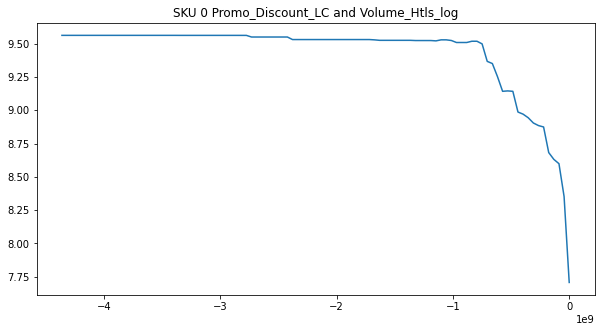

In [591]:
# plot Promo_Discount_LC and Volume_Htls_log
def plot_promo_discount_lc_volume_htls_log(data, sku):
    # plor the Promo_Discount_LC and Volume_Htls_log
    plt.figure(figsize=(10,5))
    df=data[data.SKU == sku]
    plt.plot(df.Promotional_Discount_LC, df.Volume_Htls_log)
    plt.title(f'SKU {sku} Promo_Discount_LC and Volume_Htls_log')
    plt.show()
# plot Promo_Discount_LC and Volume_Htls_log
plot_promo_discount_lc_volume_htls_log(result_df, 0)

In [61]:
constraints_table

,SKU,Brand,Pack,Size,Max_Discount_Brand_6,Max_Discount_Pack_6,Max_Discount_Brand_7,Max_Discount_Pack_7,Max_Discount_Price_Segment_6,Max_Discount_Price_Segment_7
0,0,11,0,9,-4.362497e+09,-3.830511e+10,-4.713137e+09,-3.824104e+10,-7.075328e+09,-7.727772e+09
1,1,14,0,9,-3.397813e+09,-3.830511e+10,-3.685043e+09,-3.824104e+10,-1.402168e+10,-1.569308e+10
4,3,21,3,4,-1.189053e+10,-1.313038e+10,-1.289685e+10,-1.336721e+10,-3.566363e+10,-3.560526e+10
5,4,11,0,6,-4.362497e+09,-3.830511e+10,-4.713137e+09,-3.824104e+10,-7.075328e+09,-7.727772e+09
6,5,3,0,6,-1.969668e+09,-3.830511e+10,-1.835365e+09,-3.824104e+10,-3.566363e+10,-3.560526e+10
...,...,...,...,...,...,...,...,...,...,...
88,81,2,0,6,-1.077114e+08,-3.830511e+10,-3.741703e+07,-3.824104e+10,-4.217010e+09,-4.535993e+09
90,82,1,0,8,-2.340258e+08,-3.830511e+10,-2.494979e+08,-3.824104e+10,-1.402168e+10,-1.569308e+10
92,83,5,3,0,-1.006541e+10,-1.313038e+10,-9.669847e+09,-1.336721e+10,-3.566363e+10,-3.560526e+10
93,84,11,1,13,-4.362497e+09,-4.456805e+07,-4.713137e+09,-3.855361e+07,-7.075328e+09,-7.727772e+09


In [62]:
test_data_encoded_=test_data_encoded.copy()

In [67]:
# make a prediction with the test_data_encoded_ and make a dataframe with the prediction and SKU
# change the month 

df_pred = pd.DataFrame(model.predict(test_data_encoded_), columns=['Volume_Htls_log'])
df_pred['SKU'] = test_data_encoded_['SKU']
# convert the Volume_Htls_log to Volume_Htls
df_pred['Volume_Htls'] = np.exp(df_pred['Volume_Htls_log'])
# decode the SKU
df_pred = decode_categorical_features_col(df_pred, 'SKU', label_encoders)
df_pred

,Volume_Htls_log,SKU,Volume_Htls
0,6.893345,AjMMHY,985.692932
1,6.977550,CPXipv,1072.287598
2,5.111548,CpWPBT,165.927078
3,2.778533,CpWPBT,16.095383
4,10.921472,DFBEVC,55352.195312
...,...,...,...
90,7.175040,yOnftl,1306.412720
91,6.611417,yOnftl,743.535706
92,9.005036,ykzJnG,8143.997070
93,5.523639,yvlFSF,250.545029


In [64]:
# make a prediction with the test_data_encoded_ and make a dataframe with the prediction and SKU
test_data_encoded_['Volume_Htls_log'] = model.predict(test_data_encoded_)
test_data_encoded_['Volume_Htls'] = np.exp(test_data_encoded_['Volume_Htls_log'])
test_data_encoded_['Volume_Htls'] = test_data_encoded_['Volume_Htls'].round(0)


array([ 6.893345  ,  6.9775496 ,  5.1115484 ,  2.7785325 , 10.921472  ,
        2.8909206 ,  9.014702  ,  2.6697729 , 10.5092535 ,  5.7760234 ,
        7.952103  , 10.21667   , 10.381069  ,  4.3168483 , -1.4107156 ,
        1.5163739 ,  1.3979974 , -2.8378491 ,  8.301824  ,  7.243799  ,
        4.05962   , 10.483814  ,  6.364386  ,  0.49260402, -0.9926728 ,
       10.262566  ,  3.0734851 ,  2.9925737 , -1.1945105 , 10.065964  ,
        3.7783012 , 10.645236  ,  7.920484  ,  8.289216  , 10.466252  ,
       10.700827  ,  4.254305  ,  4.3271604 , 11.378081  ,  5.8705254 ,
       -2.6180456 ,  8.319921  ,  1.3064094 , 10.101541  , -1.4793525 ,
       -1.5513685 , 11.9388    ,  7.41497   ,  5.149162  ,  5.4021606 ,
        2.3261461 ,  5.8943377 ,  4.9449525 ,  7.8874493 , 10.225088  ,
        6.811322  ,  0.5652485 , 12.510814  , 10.282398  ,  3.1715133 ,
       -2.7197146 ,  6.6971016 ,  8.827652  ,  9.318772  ,  5.296481  ,
       10.803201  ,  9.297335  ,  9.05825   , -2.292847  ,  3.85

### Prediction 6 Months

In [92]:
unique_skus = test_data_encoded_['SKU'].unique()
# Supongamos que tienes una tabla llamada "descuentos_tabla" con columnas SKU, Min_Descuento y Max_Descuento

months = [6]

# Función para calcular la predicción
def calculate_prediction(combination):
    #print(combination["SKU"].values[0])
    sku= combination["SKU"].values[0]
    month = combination["month"].values[0]

    try:

        descuentos = np.linspace(0,constraints_table.loc[constraints_table['SKU'] == sku, 'Max_Discount_Brand_6'].values[0], 300)
        combinations = list(product([sku], descuentos, [month]))


        results = []
        for combo in combinations:
            sku, descuento, month = combo
            df = test_data_encoded_[test_data_encoded_['SKU'] == sku].copy()
            #df['Promotional_Discount_LC'] = descuento
            #df['Month'] = month
            #print(df)
            prediccion = model.predict(df)
            results.append({'SKU': sku, 'month': month, 'Promotional_Discount_LC': descuento, 'Volume_Htls_log': prediccion[0]})
    
    except:
        results = [{'SKU': sku, 'month': month, 'Promotional_Discount_LC': np.nan, 'Volume_Htls_log': np.nan}]
    
    return results

# Calcular las predicciones en paralelo utilizando apply
results_6 = pd.DataFrame(list(product(unique_skus, months)), columns=['SKU', 'month']).groupby('SKU', group_keys=False).apply(calculate_prediction)

# Convertir los resultados en un DataFrame final
result_df_6 = pd.DataFrame([item for sublist in results_6.tolist() for item in sublist])

In [93]:
result_df_6

,SKU,month,Promotional_Discount_LC,Volume_Htls_log
0,0,6,0.000000e+00,6.893345
1,0,6,-1.459029e+07,6.893345
2,0,6,-2.918058e+07,6.893345
3,0,6,-4.377087e+07,6.893345
4,0,6,-5.836116e+07,6.893345
...,...,...,...,...
22805,85,6,-1.173146e+10,8.871488
22806,85,6,-1.177123e+10,8.871488
22807,85,6,-1.181099e+10,8.871488
22808,85,6,-1.185076e+10,8.871488


In [94]:
# result_df_6 drop duplicates
result_df_6 = result_df_6.drop_duplicates(subset=['SKU', 'month'], keep='last')
result_df_6

# decode the SKU
result_df_6 = decode_categorical_features_col(result_df_6, 'SKU', label_encoders)
# convert the Volume_Htls_log to Volume_Htls
result_df_6['Volume_Htls'] = np.exp(result_df_6['Volume_Htls_log'])
result_df_6

,SKU,month,Promotional_Discount_LC,Volume_Htls_log,Volume_Htls
299,AjMMHY,6,-4.362497e+09,6.893345,985.692933
599,CPXipv,6,-3.397813e+09,6.977550,1072.287561
600,CpWPBT,6,NaN,NaN,NaN
900,DFBEVC,6,-1.189053e+10,10.921472,55352.195093
1200,DGeaFa,6,-4.362497e+09,2.890921,18.009883
...,...,...,...,...,...
21609,yLPxju,6,-1.077114e+08,4.073728,58.775675
21909,yOnftl,6,-2.340258e+08,6.318756,554.882347
22209,ykzJnG,6,-1.006541e+10,9.005036,8143.996867
22509,yvlFSF,6,-4.362497e+09,5.523639,250.545045


In [81]:
result_df_6.loc[result_df_6['Volume_Htls_log'] == result_df_6['Volume_Htls_log'].max()].Volume_Htls_log.unique()

array([12.51081371])

In [129]:
unique_skus = test_data_encoded_['SKU'].unique()
# Supongamos que tienes una tabla llamada "descuentos_tabla" con columnas SKU, Min_Descuento y Max_Descuento

months = [7]

# Función para calcular la predicción
def calculate_prediction(combination):
    #print(combination["SKU"].values[0])
    sku= combination["SKU"].values[0]
    month = combination["month"].values[0]

    try:

        descuentos = np.linspace(0,constraints_table.loc[constraints_table['SKU'] == sku, 'Max_Discount_Brand_6'].values[0], 300)
        combinations = list(product([sku], descuentos, [month]))


        results = []
        for combo in combinations:
            sku, descuento, month = combo
            df = test_data_encoded_[test_data_encoded_['SKU'] == sku].copy()
            df['Other_Discounts_LC'] = descuento
            df['Month'] = month
            #print(df)
            prediccion = model.predict(df)
            results.append({'SKU': sku, 'month': month, 'Other_Discounts_LC': descuento, 'Volume_Htls_log':  prediccion[0]})
    
    except:
        results = [{'SKU': sku, 'month': month, 'Other_Discounts_LC': np.nan, 'Volume_Htls_log': np.nan}]
    
    return results

# Calcular las predicciones en paralelo utilizando apply
results_6_other = pd.DataFrame(list(product(unique_skus, months)), columns=['SKU', 'month']).groupby('SKU', group_keys=False).apply(calculate_prediction)

# Convertir los resultados en un DataFrame final
result_df_6_other = pd.DataFrame([item for sublist in results_6_other.tolist() for item in sublist])
result_df_6_other

,SKU,month,Other_Discounts_LC,Volume_Htls_log
0,0,7,0.000000e+00,-0.510413
1,0,7,-1.459029e+07,5.299816
2,0,7,-2.918058e+07,6.025880
3,0,7,-4.377087e+07,5.986331
4,0,7,-5.836116e+07,5.983319
...,...,...,...,...
22805,85,7,-1.173146e+10,10.608785
22806,85,7,-1.177123e+10,10.608785
22807,85,7,-1.181099e+10,10.608785
22808,85,7,-1.185076e+10,10.608785


In [130]:
# rename Volume_Htls_log to Volume_Htls_log_other_discount
result_df_6_other = result_df_6_other.rename(columns={'Volume_Htls_log': 'Volume_Htls_month_6_other_discount', 'Other_Discounts_LC': 'discount'})
#rename Volume_Htls_log to Volume_Htls_log_discount
result_df_6 = result_df_6.rename(columns={'Volume_Htls_log': 'Volume_Htls_month_6_discount', 'Promotional_Discount_LC': 'discount'})


In [131]:
# decode the categorical features of result_df_6 and result_df_6_other
result_df_6 = decode_categorical_features_col(result_df_6, 'SKU', label_encoders)
result_df_6_other = decode_categorical_features_col(result_df_6_other, 'SKU', label_encoders)

# inverse of the convert log
result_df_6.Volume_Htls_month_6_discount = np.exp(result_df_6.Volume_Htls_month_6_discount)
result_df_6_other.Volume_Htls_month_6_other_discount = np.exp(result_df_6_other.Volume_Htls_month_6_other_discount)


In [132]:
table_df=result_df_6.merge(result_df_6_other, how='left', on=['SKU', 'month', 'discount'])

In [133]:
table_df

,SKU,month,discount,Volume_Htls_month_6_discount,Volume_Htls_month_6_other_discount
0,AjMMHY,7,0.000000e+00,1779.198374,0.600248
1,AjMMHY,7,-1.459029e+07,3091.313016,200.299978
2,AjMMHY,7,-2.918058e+07,3482.634341,414.005946
3,AjMMHY,7,-4.377087e+07,3752.307942,397.951837
4,AjMMHY,7,-5.836116e+07,3760.099213,396.754938
...,...,...,...,...,...
22805,ztGEho,7,-1.173146e+10,10153.875488,40488.962116
22806,ztGEho,7,-1.177123e+10,10153.875488,40488.962116
22807,ztGEho,7,-1.181099e+10,10153.875488,40488.962116
22808,ztGEho,7,-1.185076e+10,10153.875488,40488.962116


In [134]:
table_df.isnull().sum()

SKU                                    0
month                                  0
discount                              10
Volume_Htls_month_6_discount          10
Volume_Htls_month_6_other_discount    10
dtype: int64

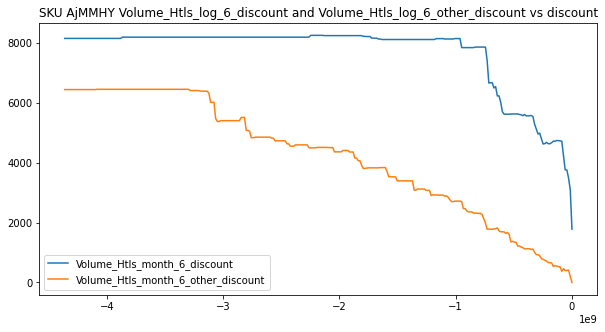

In [135]:
# plot Volume_Htls_log_6_discount and Volume_Htls_log_6_other_discount vs discount by SKU
def plot_volume_htls_log_6_discount_volume_htls_log_6_other_discount_vs_discount_by_sku(data, sku):
    # plor the Promo_Discount_LC and Volume_Htls_log

    plt.figure(figsize=(10,5))
    df=data[data.SKU == sku]
    plt.plot(df.discount, df.Volume_Htls_month_6_discount, label='Volume_Htls_month_6_discount')
    plt.plot(df.discount, df.Volume_Htls_month_6_other_discount, label='Volume_Htls_month_6_other_discount')
    plt.title(f'SKU {sku} Volume_Htls_log_6_discount and Volume_Htls_log_6_other_discount vs discount')
    plt.legend()
    plt.show()

plot_volume_htls_log_6_discount_volume_htls_log_6_other_discount_vs_discount_by_sku(table_df, 'AjMMHY')

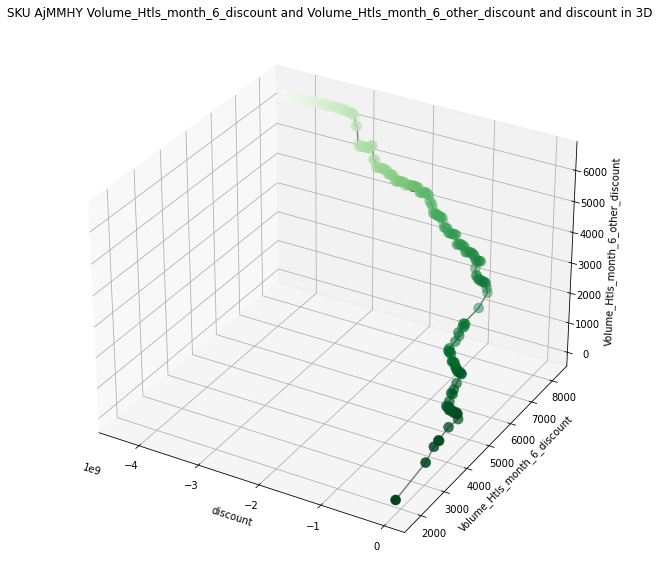

In [136]:
# plot Volume_Htls_log_6_discount and Volume_Htls_log_6_other_discount and discount in 3D 
def plot_volume_htls_log_6_discount_volume_htls_log_6_other_discount_discount_in_3d(data, sku):
    # plor the Promo_Discount_LC and Volume_Htls_log
    plt.figure(figsize=(10,10))
    df=data[data.SKU == sku]
    ax = plt.axes(projection='3d')
    ax.scatter3D(df.discount, df.Volume_Htls_month_6_discount, df.Volume_Htls_month_6_other_discount, c=df.discount, cmap='Greens', linewidth=0.5,s=100);
    # joiin the points in line  
    ax.plot3D(df.discount, df.Volume_Htls_month_6_discount, df.Volume_Htls_month_6_other_discount, 'gray')
    
    # intersection Volume_Htls_log_6_discount in X,Y,Z
    intersection_x = df[df.Volume_Htls_month_6_discount == df.Volume_Htls_month_6_discount.max()].discount.values[0]
    intersection_y = df[df.Volume_Htls_month_6_discount == df.Volume_Htls_month_6_discount.max()].Volume_Htls_month_6_discount.values[0]
    intersection_z = df[df.Volume_Htls_month_6_discount == df.Volume_Htls_month_6_discount.max()].Volume_Htls_month_6_other_discount.values[0]

    # plot the point intersection
    plt.plot(intersection_x, intersection_y, intersection_z, 'ro', markersize=10)

    ax.set_xlabel('discount')
    ax.set_ylabel('Volume_Htls_month_6_discount')
    ax.set_zlabel('Volume_Htls_month_6_other_discount')
    plt.title(f'SKU {sku} Volume_Htls_month_6_discount and Volume_Htls_month_6_other_discount and discount in 3D')
    plt.show()

plot_volume_htls_log_6_discount_volume_htls_log_6_other_discount_discount_in_3d(table_df, 'AjMMHY')

### Calculating NR and aproximating

In [68]:
# founding the last price in order to calculate the NR 
last_price_df = unified_sales_df_1.sort_values(by=['date', 'SKU']).groupby(['SKU', 'Brand', 'Pack']).last().reset_index()
last_price_df["Price_Htl"]=np.divide(last_price_df["GTO_LC"],last_price_df["Volume_Htls"])
last_price_df=last_price_df[['SKU', 'Brand', 'Pack', 'Price_Htl','VILC_LC']]
last_price_df

,SKU,Brand,Pack,Price_Htl,VILC_LC
0,ATPigG,XVgSwQ,gydWlH,-inf,-1.000000e-02
1,AjMMHY,ZVDcKH,GUbqnp,5.803475e+05,1.601311e+09
2,AnHGGW,tcqKyp,gydWlH,8.558920e+05,-1.484199e+04
3,ArCILz,edvmUB,VmwBmS,4.885866e+05,8.330330e+05
4,BKADKy,MoNlrL,GUbqnp,3.437783e+05,2.205247e+04
...,...,...,...,...,...
476,zmYUSj,UvlSYO,GUbqnp,9.332570e+05,-7.269251e+05
477,zmodzP,ZWPpTt,mmgsXK,2.848280e+05,-1.402662e+04
478,zsSGou,EpUbak,GUbqnp,-inf,-3.737700e+02
479,zsSGou,nHFLwk,GUbqnp,-inf,0.000000e+00


In [69]:
# merge last_price_df with table_df
table_df_=table_df.merge(last_price_df, how='left', on=['SKU'])
table_df_=table_df_.drop_duplicates(subset=['SKU','discount'], keep='last')
table_df_

NameError: name 'table_df' is not defined

In [90]:
result_df_6

,SKU,month,Promotional_Discount_LC,Volume_Htls_log,Volume_Htls
299,AjMMHY,7,-4.362497e+09,6.893345,985.692933
599,CPXipv,7,-3.397813e+09,6.977550,1072.287561
600,CpWPBT,7,NaN,NaN,NaN
900,DFBEVC,7,-1.189053e+10,10.921472,55352.195093
1200,DGeaFa,7,-4.362497e+09,2.890921,18.009883
...,...,...,...,...,...
21011,yLPxju,7,-1.077114e+08,4.073728,58.775675
21311,yOnftl,7,-2.340258e+08,6.318756,554.882347
21611,ykzJnG,7,-1.006541e+10,9.005036,8143.996867
21911,yvlFSF,7,-4.362497e+09,5.523639,250.545045


In [95]:
# merge df_pred with last_price_df
df_pred_=result_df_6.merge(last_price_df, how='left', on=['SKU'])
df_pred_=result_df_6.drop_duplicates(subset=['SKU','month'], keep='last')
df_pred_

,SKU,month,Promotional_Discount_LC,Volume_Htls_log,Volume_Htls
299,AjMMHY,6,-4.362497e+09,6.893345,985.692933
599,CPXipv,6,-3.397813e+09,6.977550,1072.287561
600,CpWPBT,6,NaN,NaN,NaN
900,DFBEVC,6,-1.189053e+10,10.921472,55352.195093
1200,DGeaFa,6,-4.362497e+09,2.890921,18.009883
...,...,...,...,...,...
21609,yLPxju,6,-1.077114e+08,4.073728,58.775675
21909,yOnftl,6,-2.340258e+08,6.318756,554.882347
22209,ykzJnG,6,-1.006541e+10,9.005036,8143.996867
22509,yvlFSF,6,-4.362497e+09,5.523639,250.545045


In [96]:
# mmerge df_pred_ with last_price_df
df_pred_=df_pred_.merge(last_price_df, how='left', on=['SKU'])
df_pred_=df_pred_.drop_duplicates(subset=['SKU'], keep='last')
df_pred_

,SKU,month,Promotional_Discount_LC,Volume_Htls_log,Volume_Htls,Brand,Pack,Price_Htl,VILC_LC
0,AjMMHY,6,-4.362497e+09,6.893345,985.692933,ZVDcKH,GUbqnp,5.803475e+05,1.601311e+09
1,CPXipv,6,-3.397813e+09,6.977550,1072.287561,ZfEWxz,GUbqnp,6.559624e+05,2.371762e+08
3,CpWPBT,6,NaN,NaN,NaN,erVQIv,GUbqnp,5.647232e+05,-3.289714e+04
4,DFBEVC,6,-1.189053e+10,10.921472,55352.195093,oKraYa,mmgsXK,3.872157e+05,4.344674e+09
5,DGeaFa,6,-4.362497e+09,2.890921,18.009883,ZVDcKH,GUbqnp,7.157747e+05,4.899113e+06
...,...,...,...,...,...,...,...,...,...
90,yLPxju,6,-1.077114e+08,4.073728,58.775675,FnpxCq,GUbqnp,-inf,-7.417737e+04
93,yOnftl,6,-2.340258e+08,6.318756,554.882347,FPgJHY,gydWlH,6.440287e+05,3.108710e+08
94,ykzJnG,6,-1.006541e+10,9.005036,8143.996867,OmUaam,mmgsXK,5.228772e+05,1.029883e+09
95,yvlFSF,6,-4.362497e+09,5.523639,250.545045,ZVDcKH,VmwBmS,4.601096e+05,2.614264e+07


In [97]:
# calculate Net Revenue
df_pred_["NR"]=np.multiply(df_pred_["Volume_Htls"],df_pred_["Price_Htl"])
# MACO_LC= Net_Revenue_LC_volume_htls_log_6_discount - VILC_LC
df_pred_["MACO_LC"]=np.subtract(df_pred_["NR"],df_pred_["VILC_LC"])
df_pred_

,SKU,month,Promotional_Discount_LC,Volume_Htls_log,Volume_Htls,Brand,Pack,Price_Htl,VILC_LC,NR,MACO_LC
0,AjMMHY,6,-4.362497e+09,6.893345,985.692933,ZVDcKH,GUbqnp,5.803475e+05,1.601311e+09,5.720444e+08,-1.029267e+09
1,CPXipv,6,-3.397813e+09,6.977550,1072.287561,ZfEWxz,GUbqnp,6.559624e+05,2.371762e+08,7.033803e+08,4.662041e+08
3,CpWPBT,6,NaN,NaN,NaN,erVQIv,GUbqnp,5.647232e+05,-3.289714e+04,NaN,NaN
4,DFBEVC,6,-1.189053e+10,10.921472,55352.195093,oKraYa,mmgsXK,3.872157e+05,4.344674e+09,2.143324e+10,1.708857e+10
5,DGeaFa,6,-4.362497e+09,2.890921,18.009883,ZVDcKH,GUbqnp,7.157747e+05,4.899113e+06,1.289102e+07,7.991905e+06
...,...,...,...,...,...,...,...,...,...,...,...
90,yLPxju,6,-1.077114e+08,4.073728,58.775675,FnpxCq,GUbqnp,-inf,-7.417737e+04,-inf,-inf
93,yOnftl,6,-2.340258e+08,6.318756,554.882347,FPgJHY,gydWlH,6.440287e+05,3.108710e+08,3.573601e+08,4.648908e+07
94,ykzJnG,6,-1.006541e+10,9.005036,8143.996867,OmUaam,mmgsXK,5.228772e+05,1.029883e+09,4.258310e+09,3.228427e+09
95,yvlFSF,6,-4.362497e+09,5.523639,250.545045,ZVDcKH,VmwBmS,4.601096e+05,2.614264e+07,1.152782e+08,8.913554e+07


In [98]:
# to csv
df_pred_.to_csv('df_pred_6_month.csv', index=False)

In [139]:
table_df_["Net_Revenue_LC_6_discount"]=np.multiply(table_df_["Volume_Htls_month_6_discount"],table_df_["Price_Htl"])
table_df_["Net_Revenue_LC_6_other_discount"]=np.multiply(table_df_["Volume_Htls_month_6_other_discount"],table_df_["Price_Htl"])
table_df_

,SKU,month,discount,Volume_Htls_month_6_discount,Volume_Htls_month_6_other_discount,Brand,Pack,Price_Htl,VILC_LC,Net_Revenue_LC_6_discount,Net_Revenue_LC_6_other_discount
0,AjMMHY,7,0.000000e+00,1779.198374,0.600248,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,1.032553e+09,3.483522e+05
1,AjMMHY,7,-1.459029e+07,3091.313016,200.299978,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,1.794036e+09,1.162436e+08
2,AjMMHY,7,-2.918058e+07,3482.634341,414.005946,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,2.021138e+09,2.402673e+08
3,AjMMHY,7,-4.377087e+07,3752.307942,397.951837,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,2.177642e+09,2.309503e+08
4,AjMMHY,7,-5.836116e+07,3760.099213,396.754938,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,2.182164e+09,2.302557e+08
...,...,...,...,...,...,...,...,...,...,...,...
23414,ztGEho,7,-1.173146e+10,10153.875488,40488.962116,oKraYa,GUbqnp,512090.249806,1.884897e+09,5.199701e+09,2.073400e+10
23415,ztGEho,7,-1.177123e+10,10153.875488,40488.962116,oKraYa,GUbqnp,512090.249806,1.884897e+09,5.199701e+09,2.073400e+10
23416,ztGEho,7,-1.181099e+10,10153.875488,40488.962116,oKraYa,GUbqnp,512090.249806,1.884897e+09,5.199701e+09,2.073400e+10
23417,ztGEho,7,-1.185076e+10,10153.875488,40488.962116,oKraYa,GUbqnp,512090.249806,1.884897e+09,5.199701e+09,2.073400e+10


In [140]:
# calculating the other metrics
# MACO_LC= Net_Revenue_LC_volume_htls_log_6_discount - VILC_LC
table_df_["MACO_LC_6_discount"]=table_df_["Net_Revenue_LC_6_discount"]-table_df_["VILC_LC"]
table_df_["MACO_LC_6_other_discount"]=table_df_["Net_Revenue_LC_6_other_discount"]-table_df_["VILC_LC"]
table_df_


,SKU,month,discount,Volume_Htls_month_6_discount,Volume_Htls_month_6_other_discount,Brand,Pack,Price_Htl,VILC_LC,Net_Revenue_LC_6_discount,Net_Revenue_LC_6_other_discount,MACO_LC_6_discount,MACO_LC_6_other_discount
0,AjMMHY,7,0.000000e+00,1779.198374,0.600248,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,1.032553e+09,3.483522e+05,-5.687580e+08,-1.600963e+09
1,AjMMHY,7,-1.459029e+07,3091.313016,200.299978,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,1.794036e+09,1.162436e+08,1.927245e+08,-1.485068e+09
2,AjMMHY,7,-2.918058e+07,3482.634341,414.005946,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,2.021138e+09,2.402673e+08,4.198268e+08,-1.361044e+09
3,AjMMHY,7,-4.377087e+07,3752.307942,397.951837,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,2.177642e+09,2.309503e+08,5.763312e+08,-1.370361e+09
4,AjMMHY,7,-5.836116e+07,3760.099213,396.754938,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,2.182164e+09,2.302557e+08,5.808528e+08,-1.371056e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23414,ztGEho,7,-1.173146e+10,10153.875488,40488.962116,oKraYa,GUbqnp,512090.249806,1.884897e+09,5.199701e+09,2.073400e+10,3.314803e+09,1.884911e+10
23415,ztGEho,7,-1.177123e+10,10153.875488,40488.962116,oKraYa,GUbqnp,512090.249806,1.884897e+09,5.199701e+09,2.073400e+10,3.314803e+09,1.884911e+10
23416,ztGEho,7,-1.181099e+10,10153.875488,40488.962116,oKraYa,GUbqnp,512090.249806,1.884897e+09,5.199701e+09,2.073400e+10,3.314803e+09,1.884911e+10
23417,ztGEho,7,-1.185076e+10,10153.875488,40488.962116,oKraYa,GUbqnp,512090.249806,1.884897e+09,5.199701e+09,2.073400e+10,3.314803e+09,1.884911e+10


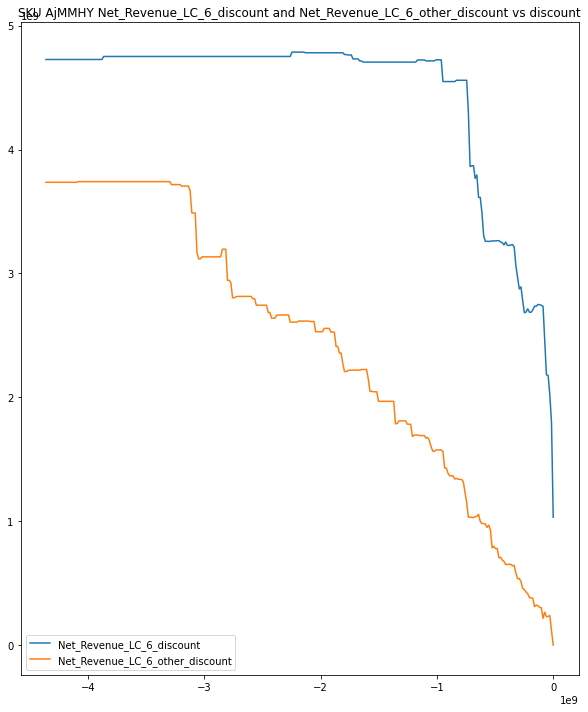

In [141]:
# plot Net_Revenue_LC_6_discount and Net_Revenue_LC_6_other_discount vs discount by SKU
def plot_net_revenue_lc_6_discount_net_revenue_lc_6_other_discount_vs_discount_by_sku(data, sku):
    # plor the Promo_Discount_LC and Volume_Htls_log

    plt.figure(figsize=(10,12))
    df=data[data.SKU == sku]
    plt.plot(df.discount, df.Net_Revenue_LC_6_discount, label='Net_Revenue_LC_6_discount')
    plt.plot(df.discount, df.Net_Revenue_LC_6_other_discount, label='Net_Revenue_LC_6_other_discount')
    plt.title(f'SKU {sku} Net_Revenue_LC_6_discount and Net_Revenue_LC_6_other_discount vs discount')
    plt.legend()
    plt.show()	

plot_net_revenue_lc_6_discount_net_revenue_lc_6_other_discount_vs_discount_by_sku(table_df_, 'AjMMHY')

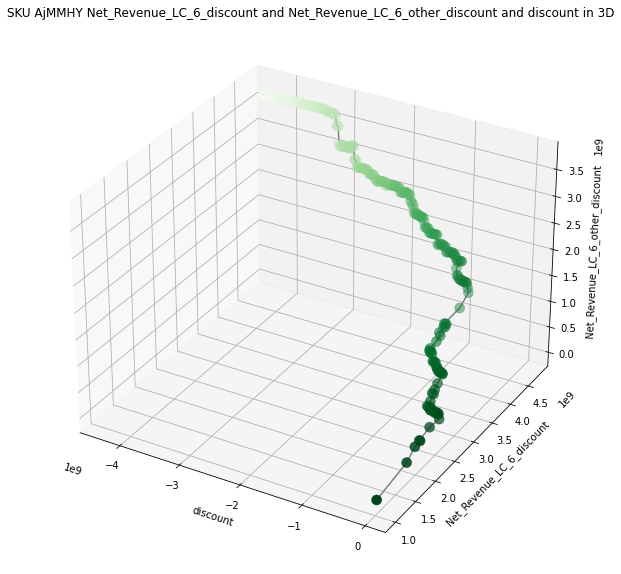

In [143]:
def plot_net_revenue_lc_6_discount_net_revenue_lc_6_other_discount_vs_discount_by_sku_in_3d(data, sku):
    # plor the Promo_Discount_LC and Volume_Htls_log
    plt.figure(figsize=(10,10))
    df=data[data.SKU == sku]
    ax = plt.axes(projection='3d')
    ax.scatter3D(df.discount, df.Net_Revenue_LC_6_discount, df.Net_Revenue_LC_6_other_discount, c=df.discount, cmap='Greens', linewidth=0.5,s=100);
    # joiin the points in line  
    ax.plot3D(df.discount, df.Net_Revenue_LC_6_discount, df.Net_Revenue_LC_6_other_discount, 'gray')
    
    # intersection Volume_Htls_log_6_discount in X,Y,Z
    # intersection_x = df[df.Volume_Htls_log_6_discount == df.Volume_Htls_log_6_discount.max()].discount.values[0]
    # intersection_y = df[df.Volume_Htls_log_6_discount == df.Volume_Htls_log_6_discount.max()].Volume_Htls_log_6_discount.values[0]
    # intersection_z = df[df.Volume_Htls_log_6_discount == df.Volume_Htls_log_6_discount.max()].Volume_Htls_log_6_other_discount.values[0]

    # # plot the point intersection
    # plt.plot(intersection_x, intersection_y, intersection_z, 'ro', markersize=10)

    ax.set_xlabel('discount')
    ax.set_ylabel('Net_Revenue_LC_6_discount')
    ax.set_zlabel('Net_Revenue_LC_6_other_discount')
    plt.title(f'SKU {sku} Net_Revenue_LC_6_discount and Net_Revenue_LC_6_other_discount and discount in 3D')
    plt.show()

plot_net_revenue_lc_6_discount_net_revenue_lc_6_other_discount_vs_discount_by_sku_in_3d(table_df_, 'AjMMHY')

In [144]:
table_df_.to_csv('Curves_month_7_predicton_300.csv', index=False)

In [145]:
table_df_

,SKU,month,discount,Volume_Htls_month_6_discount,Volume_Htls_month_6_other_discount,Brand,Pack,Price_Htl,VILC_LC,Net_Revenue_LC_6_discount,Net_Revenue_LC_6_other_discount,MACO_LC_6_discount,MACO_LC_6_other_discount
0,AjMMHY,7,0.000000e+00,1779.198374,0.600248,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,1.032553e+09,3.483522e+05,-5.687580e+08,-1.600963e+09
1,AjMMHY,7,-1.459029e+07,3091.313016,200.299978,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,1.794036e+09,1.162436e+08,1.927245e+08,-1.485068e+09
2,AjMMHY,7,-2.918058e+07,3482.634341,414.005946,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,2.021138e+09,2.402673e+08,4.198268e+08,-1.361044e+09
3,AjMMHY,7,-4.377087e+07,3752.307942,397.951837,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,2.177642e+09,2.309503e+08,5.763312e+08,-1.370361e+09
4,AjMMHY,7,-5.836116e+07,3760.099213,396.754938,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,2.182164e+09,2.302557e+08,5.808528e+08,-1.371056e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23414,ztGEho,7,-1.173146e+10,10153.875488,40488.962116,oKraYa,GUbqnp,512090.249806,1.884897e+09,5.199701e+09,2.073400e+10,3.314803e+09,1.884911e+10
23415,ztGEho,7,-1.177123e+10,10153.875488,40488.962116,oKraYa,GUbqnp,512090.249806,1.884897e+09,5.199701e+09,2.073400e+10,3.314803e+09,1.884911e+10
23416,ztGEho,7,-1.181099e+10,10153.875488,40488.962116,oKraYa,GUbqnp,512090.249806,1.884897e+09,5.199701e+09,2.073400e+10,3.314803e+09,1.884911e+10
23417,ztGEho,7,-1.185076e+10,10153.875488,40488.962116,oKraYa,GUbqnp,512090.249806,1.884897e+09,5.199701e+09,2.073400e+10,3.314803e+09,1.884911e+10


In [146]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

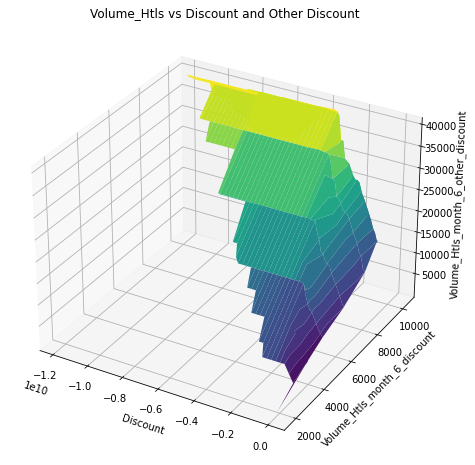

In [148]:
def plot_3d_surface(dataframe, x_col, y_col, z_col, x_label, y_label, z_label, title,figsize=(10, 8)):
    # Definir una malla continua para x (discount)
    

    x_values = np.linspace(dataframe[x_col].min(), dataframe[x_col].max(), 100)

    # Crear una malla 2D con todas las combinaciones de x y y (discount y Volume_Htls_log_6_discount)
    X, Y = np.meshgrid(x_values, dataframe[y_col])
    points = np.array([dataframe[x_col], dataframe[y_col]]).T
    Z = griddata(points, dataframe[z_col], (X, Y), method='linear')

    # Crear la figura 3D
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection='3d')

    # Graficar la superficie
    ax.plot_surface(X, Y, Z, cmap='viridis')

    # Configurar etiquetas de los ejes y título
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_zlabel(z_label)
    ax.set_title(title)

    # Mostrar la gráfica
    plt.show()

# Llamar a la función con los parámetros adecuados
plot_3d_surface(table_df_.loc[table_df_.SKU=='ztGEho'], 'discount', 'Volume_Htls_month_6_discount', 'Volume_Htls_month_6_other_discount',
                'Discount', 'Volume_Htls_month_6_discount','Volume_Htls_month_6_other_discount', 'Volume_Htls vs Discount and Other Discount') 

In [160]:
_df_teste=table_df_.loc[table_df_.SKU=='AjMMHY']
_df_teste

,SKU,month,discount,Volume_Htls_month_6_discount,Volume_Htls_month_6_other_discount,Brand,Pack,Price_Htl,VILC_LC,Net_Revenue_LC_6_discount,Net_Revenue_LC_6_other_discount,MACO_LC_6_discount,MACO_LC_6_other_discount
0,AjMMHY,7,0.000000e+00,1779.198374,0.600248,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,1.032553e+09,3.483522e+05,-5.687580e+08,-1.600963e+09
1,AjMMHY,7,-1.459029e+07,3091.313016,200.299978,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,1.794036e+09,1.162436e+08,1.927245e+08,-1.485068e+09
2,AjMMHY,7,-2.918058e+07,3482.634341,414.005946,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,2.021138e+09,2.402673e+08,4.198268e+08,-1.361044e+09
3,AjMMHY,7,-4.377087e+07,3752.307942,397.951837,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,2.177642e+09,2.309503e+08,5.763312e+08,-1.370361e+09
4,AjMMHY,7,-5.836116e+07,3760.099213,396.754938,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,2.182164e+09,2.302557e+08,5.808528e+08,-1.371056e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,AjMMHY,7,-4.304136e+09,8144.983300,6437.340436,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,4.726921e+09,3.735894e+09,3.125609e+09,2.134583e+09
296,AjMMHY,7,-4.318726e+09,8144.983300,6437.340436,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,4.726921e+09,3.735894e+09,3.125609e+09,2.134583e+09
297,AjMMHY,7,-4.333316e+09,8144.983300,6437.340436,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,4.726921e+09,3.735894e+09,3.125609e+09,2.134583e+09
298,AjMMHY,7,-4.347907e+09,8144.983300,6437.340436,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,4.726921e+09,3.735894e+09,3.125609e+09,2.134583e+09


In [169]:
_df_teste["discount"]=np.abs(_df_teste["discount"])
_df_teste


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,SKU,month,discount,Volume_Htls_month_6_discount,Volume_Htls_month_6_other_discount,Brand,Pack,Price_Htl,VILC_LC,Net_Revenue_LC_6_discount,Net_Revenue_LC_6_other_discount,MACO_LC_6_discount,MACO_LC_6_other_discount
0,AjMMHY,7,0.000000e+00,1779.198374,0.600248,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,1.032553e+09,3.483522e+05,-5.687580e+08,-1.600963e+09
1,AjMMHY,7,1.459029e+07,3091.313016,200.299978,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,1.794036e+09,1.162436e+08,1.927245e+08,-1.485068e+09
2,AjMMHY,7,2.918058e+07,3482.634341,414.005946,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,2.021138e+09,2.402673e+08,4.198268e+08,-1.361044e+09
3,AjMMHY,7,4.377087e+07,3752.307942,397.951837,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,2.177642e+09,2.309503e+08,5.763312e+08,-1.370361e+09
4,AjMMHY,7,5.836116e+07,3760.099213,396.754938,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,2.182164e+09,2.302557e+08,5.808528e+08,-1.371056e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,AjMMHY,7,4.304136e+09,8144.983300,6437.340436,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,4.726921e+09,3.735894e+09,3.125609e+09,2.134583e+09
296,AjMMHY,7,4.318726e+09,8144.983300,6437.340436,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,4.726921e+09,3.735894e+09,3.125609e+09,2.134583e+09
297,AjMMHY,7,4.333316e+09,8144.983300,6437.340436,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,4.726921e+09,3.735894e+09,3.125609e+09,2.134583e+09
298,AjMMHY,7,4.347907e+09,8144.983300,6437.340436,ZVDcKH,GUbqnp,580347.476104,1.601311e+09,4.726921e+09,3.735894e+09,3.125609e+09,2.134583e+09


In [162]:
constraints_table

,SKU,Brand,Pack,Size,Max_Discount_Brand_6,Max_Discount_Pack_6,Max_Discount_Brand_7,Max_Discount_Pack_7,Max_Discount_Price_Segment_6,Max_Discount_Price_Segment_7
0,0,11,0,9,-4.362497e+09,-3.830511e+10,-4.713137e+09,-3.824104e+10,-7.075328e+09,-7.727772e+09
1,1,14,0,9,-3.397813e+09,-3.830511e+10,-3.685043e+09,-3.824104e+10,-1.402168e+10,-1.569308e+10
4,3,21,3,4,-1.189053e+10,-1.313038e+10,-1.289685e+10,-1.336721e+10,-3.566363e+10,-3.560526e+10
5,4,11,0,6,-4.362497e+09,-3.830511e+10,-4.713137e+09,-3.824104e+10,-7.075328e+09,-7.727772e+09
6,5,3,0,6,-1.969668e+09,-3.830511e+10,-1.835365e+09,-3.824104e+10,-3.566363e+10,-3.560526e+10
...,...,...,...,...,...,...,...,...,...,...
88,81,2,0,6,-1.077114e+08,-3.830511e+10,-3.741703e+07,-3.824104e+10,-4.217010e+09,-4.535993e+09
90,82,1,0,8,-2.340258e+08,-3.830511e+10,-2.494979e+08,-3.824104e+10,-1.402168e+10,-1.569308e+10
92,83,5,3,0,-1.006541e+10,-1.313038e+10,-9.669847e+09,-1.336721e+10,-3.566363e+10,-3.560526e+10
93,84,11,1,13,-4.362497e+09,-4.456805e+07,-4.713137e+09,-3.855361e+07,-7.075328e+09,-7.727772e+09


# Optimizing

In [170]:
df=_df_teste.copy()

In [178]:
budget= -1.0e+20

# Crear una función objetivo para maximizar el net revenue total
def objective_function(discounts):
    total_net_revenue = 0
    total_discount = 0
    for sku in df['SKU'].unique():
        subset = df[df['SKU'] == sku]
        optimal_discount = discounts[df['SKU'].unique().tolist().index(sku)]
        net_revenue = subset['Net_Revenue_LC_6_discount'].values[0] if optimal_discount > 0 else subset['Net_Revenue_LC_6_other_discount'].values[0]
        total_net_revenue += net_revenue
        total_discount += optimal_discount
    return -total_net_revenue  # Minimizamos el negativo para maximizar el net revenue

# Definir las restricciones de descuento y presupuesto
bounds = [(0, 4.362497e+09) for _ in df['SKU'].unique()]  # Descuentos entre 0 y 1.0
constraints = [{'type': 'ineq', 'fun': lambda discounts: budget - sum(discounts)}]  # Restricción de presupuesto

# Ejecutar la optimización con restricción de presupuesto
initial_guess = [0.0 for _ in df['SKU'].unique()]  # Adivinanza inicial para los descuentos
result = minimize(objective_function, initial_guess,bounds=bounds, constraints=constraints)

# Obtener los descuentos óptimos
optimal_discounts = result.x

# Imprimir los descuentos óptimos
for sku, discount in zip(df['SKU'].unique(), optimal_discounts):
    print(f"SKU: {sku}, Descuento Óptimo: {discount:.2f}")

# Calcular el net revenue total con los descuentos óptimos
total_optimal_net_revenue = -result.fun  # Recuerda que minimizamos el negativo
print(f"Net Revenue Total Óptimo: {total_optimal_net_revenue:.2f}")

SKU: AjMMHY, Descuento Óptimo: 4260250.98
Net Revenue Total Óptimo: 1032553285.67


Valor óptimo de Discount: 0.0
Valor óptimo de Métrica 1: -1779.1983737161834
Valor óptimo de Métrica 2: -0.6002476664957537
Valor óptimo de la Métrica Conjunta: nan


invalid value encountered in subtract


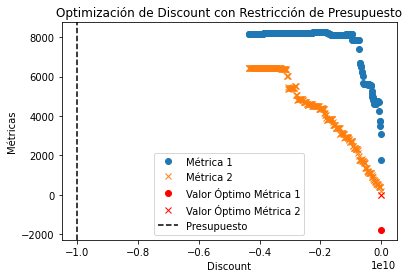

In [161]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt


# Definir la función objetivo que toma discount como entrada y devuelve la métrica conjunta
def objective_function(params):
    discount, budget = params
    subset = _df_teste[_df_teste['discount'] == discount]
    metric_1 = -subset['Net_Revenue_LC_6_discount'].mean()  # Minimizar la métrica 1
    metric_2 = -subset['Net_Revenue_LC_6_other_discount'].mean()  # Minimizar la métrica 2
    
    # Aplicar restricción de presupuesto
    if discount > budget:
        return np.inf  # Penalizar valores de discount que superen el presupuesto
    else:
        return metric_1 + metric_2  # Minimizar la suma de ambas métricas

# Presupuesto disponible
budget = -1.0e+10

# Inicializar el valor inicial para la optimización
initial_discount = 0.0

# Realizar la optimización con restricción de presupuesto
result = minimize(objective_function, (initial_discount, budget), bounds=[(None, None), (None, 0.0)])

# Obtener el valor óptimo de discount
optimal_discount = result.x[0]
optimal_metric = -result.fun  # El valor óptimo de la métrica conjunta

# Obtener el valor óptimo de las métricas individuales
subset = _df_teste[_df_teste['discount'] == optimal_discount]
optimal_metric_1 = -subset['Net_Revenue_LC_6_other_discount'].mean()
optimal_metric_2 = -subset['Volume_Htls_month_6_other_discount'].mean()

print(f"Valor óptimo de Discount: {optimal_discount}")
print(f"Valor óptimo de Métrica 1: {optimal_metric_1}")
print(f"Valor óptimo de Métrica 2: {optimal_metric_2}")
print(f"Valor óptimo de la Métrica Conjunta: {optimal_metric}")

# Visualizar los resultados
plt.plot(_df_teste['discount'], _df_teste['Volume_Htls_month_6_discount'], 'o', label='Métrica 1')
plt.plot(_df_teste['discount'], _df_teste['Volume_Htls_month_6_other_discount'], 'x', label='Métrica 2')
plt.plot(optimal_discount, optimal_metric_1, 'ro', label='Valor Óptimo Métrica 1')
plt.plot(optimal_discount, optimal_metric_2, 'rx', label='Valor Óptimo Métrica 2')
plt.axvline(x=budget, color='k', linestyle='--', label='Presupuesto')
plt.xlabel('Discount')
plt.ylabel('Métricas')
plt.legend()
plt.title('Optimización de Discount con Restricción de Presupuesto')
plt.show()

In [ ]:
# This is not making sense

In [785]:
lll

NameError: name 'lll' is not defined

### Make predictions with pred data in 2 months  for each SKU

In [27]:
filtered_final_sales_df = final_sales_df[final_sales_df['SKU'].isin(valid_sku_condition[valid_sku_condition].index)].reset_index()
filtered_final_sales_df.drop(columns=['Date','Year'], inplace=True)
filtered_final_sales_df

,SKU,Month,GTO_LC,Promotional_Discount_LC,Other_Discounts_LC,Total_Discounts_LC,Retail_Sales_Index,Unemployment_Rate,CPI,Gross_Domestic_Saving,GDP,Month_sin,Month_cos,Volume_Htls
0,yvlFSF,1,1.650060e+08,0.00,-8.518344e+06,-8.518344e+06,92.376274,10.856350,98.286865,125344.000,871349.94,0.500000,8.660254e-01,348.97
1,yvlFSF,2,1.407918e+08,0.00,-6.894289e+06,-6.894289e+06,96.299010,10.856350,98.387115,125344.000,871349.94,0.866025,5.000000e-01,299.12
2,yvlFSF,3,2.035238e+08,58823.53,-1.006023e+07,-1.000141e+07,96.791115,10.856350,98.693160,125344.000,871349.94,1.000000,6.123234e-17,413.38
3,yvlFSF,4,1.634776e+08,3610631.66,-1.817841e+07,-1.456778e+07,101.030220,10.408203,98.962450,125344.000,878498.00,0.866025,-5.000000e-01,334.85
4,yvlFSF,5,1.786534e+08,-1101525.81,-1.216304e+07,-1.326457e+07,103.469270,10.408203,99.380250,125344.000,878498.00,0.500000,-8.660254e-01,361.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3760,DgWkAg,1,9.539665e+08,-445090.76,-3.025857e+08,-3.030307e+08,123.191780,10.748787,125.377270,87175.984,993436.10,0.500000,8.660254e-01,1345.81
3761,DgWkAg,2,2.443451e+07,0.00,-6.298340e+05,-6.298340e+05,123.458660,10.748787,126.791450,87175.984,993436.10,0.866025,5.000000e-01,34.43
3762,DgWkAg,3,1.638859e+07,0.00,-1.780080e+05,-1.780080e+05,119.802900,10.748787,127.926285,87175.984,993436.10,1.000000,6.123234e-17,23.05
3763,DgWkAg,4,5.297985e+06,0.00,-1.480706e+05,-1.480706e+05,126.445770,11.872091,128.586430,87175.984,982459.80,0.866025,-5.000000e-01,7.54


In [28]:
filtered_final_sales_df.SKU.nunique()

92

### LabelEncoder for categorical variables and test train split

In [29]:
X = filtered_final_sales_df.drop('Volume_Htls', axis=1)
y = filtered_final_sales_df['Volume_Htls']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

# Instantiate the standard scaler and one hot encoder
scaler = StandardScaler()
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')

num_tuple = (scaler, num_selector)
cat_tuple = (ohe, cat_selector)

col_transformer = make_column_transformer(num_tuple, cat_tuple, remainder = 'passthrough')
col_transformer.fit(X_train)

X_train_processed = col_transformer.transform(X_train)
X_test_processed = col_transformer.transform(X_test)
X_valid_processed = col_transformer.transform(X_valid)

variables = []

for x in list(col_transformer.get_feature_names_out()):
    x_ = x.replace('standardscaler_','').replace('onehotencoder_','')
    variables.append(x_)

X_train = pd.DataFrame(X_train_processed, columns = variables, index = X_train.index)
X_test = pd.DataFrame(X_test_processed, columns = variables, index = X_test.index)
X_valid = pd.DataFrame(X_valid_processed, columns = variables, index = X_valid.index)
X_train.head()

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.


,_Month,_GTO_LC,_Promotional_Discount_LC,_Other_Discounts_LC,_Total_Discounts_LC,_Retail_Sales_Index,_Unemployment_Rate,_CPI,_Gross_Domestic_Saving,_GDP,...,_SKU_vzDAUw,_SKU_wGeFqS,_SKU_wTKjmX,_SKU_wgadDW,_SKU_yOnftl,_SKU_ykzJnG,_SKU_yoBrZu,_SKU_yvlFSF,_SKU_zNJmaD,_SKU_ztGEho
974,1.075898,0.646131,0.012856,0.186303,0.141725,-0.591908,1.295358,-0.733788,-0.092282,-0.754554,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1473,0.504505,-0.274258,0.189639,0.095957,0.167572,1.260939,-0.758255,0.899191,-0.560197,0.917053,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2466,-1.209673,-0.370774,0.215233,0.370144,0.379601,0.511278,-0.242204,0.203212,-0.560197,0.757628,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2793,-1.209673,-0.365471,0.215649,0.371925,0.381107,-0.200111,-0.377789,-0.840346,-0.092282,-0.635701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021,-1.495370,-0.365797,0.215422,0.358763,0.371446,-0.798298,-0.377789,-0.862114,-0.092282,-0.635701,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Check to see if the model has multicollinearity: if a variable has a VIF value higher than 5, it is recommended to drop this variable from the model given that the value added is not considerable/robust. 

In [30]:
def calculate_vif(df):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data

calculate_vif(X_train)

divide by zero encountered in scalar divide


,Variable,VIF
0,_Month,3.118012
1,_GTO_LC,9.792561
2,_Promotional_Discount_LC,inf
3,_Other_Discounts_LC,inf
4,_Total_Discounts_LC,inf
...,...,...
99,_SKU_ykzJnG,1.006603
100,_SKU_yoBrZu,1.011525
101,_SKU_yvlFSF,1.021112
102,_SKU_zNJmaD,1.011673


## Training

In [31]:
# Regression model list to try on a loop
models = []
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('ElasticNet', ElasticNet()))
models.append(('SVR', SVR()))
models.append(('DecisionTree', DecisionTreeRegressor()))
models.append(('ExtraTrees', ExtraTreesRegressor()))
models.append(('AdaBoost', AdaBoostRegressor()))
models.append(('Bagging', BaggingRegressor()))
models.append(('BayesianRidge', BayesianRidge()))
models.append(('GradientBoosting', GradientBoostingRegressor()))
models.append(('RandomForest', RandomForestRegressor()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('XGBoost', XGBRegressor()))
models.append(('LightGBM', LGBMRegressor()))
models.append(('CatBoost', CatBoostRegressor()))

Indicating a desire to maximize the negative value of the RMSE, which is equivalent to minimizing the actual RMSE. The intent of doing a `KFold` loop is to select the model that shows the best preliminary performance.

In [32]:
resultados = []
nombres = []
scoring = 'neg_root_mean_squared_error'

for nombre, model in models:
    kfold = KFold(n_splits=10, random_state=None)
    cv_resultados = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    resultados.append(cv_resultados)
    nombres.append(nombre)
    msg = f'{nombre}: {cv_resultados.mean()} ({cv_resultados.std()})'
    print(msg)

LR: -5040.390219020688 (863.7195033498913)
Ridge: -5073.168799767367 (854.2335864404764)
Lasso: -5039.985977774553 (859.9399587782923)
ElasticNet: -20671.411356026303 (4816.495382807253)
SVR: -60817.654857381014 (8813.508227239068)
DecisionTree: -7309.559758455706 (2381.0842872817166)
ExtraTrees: -3934.896359215788 (1447.188630166988)
AdaBoost: -10813.675693939329 (1916.7508022237098)
Bagging: -6183.914960729636 (1212.1977965493024)
BayesianRidge: -5043.2986570336125 (854.056262330998)
GradientBoosting: -4539.107725631051 (742.7277696259533)
RandomForest: -5271.992423470771 (718.7814148809898)
KNN: -12877.339182450643 (1912.4734035173647)
XGBoost: -4555.2504597338 (894.0947558168324)
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1334
[LightGBM] [Info] Number of data points in the train set: 2168, number of used features: 76
[LightGBM] [Info

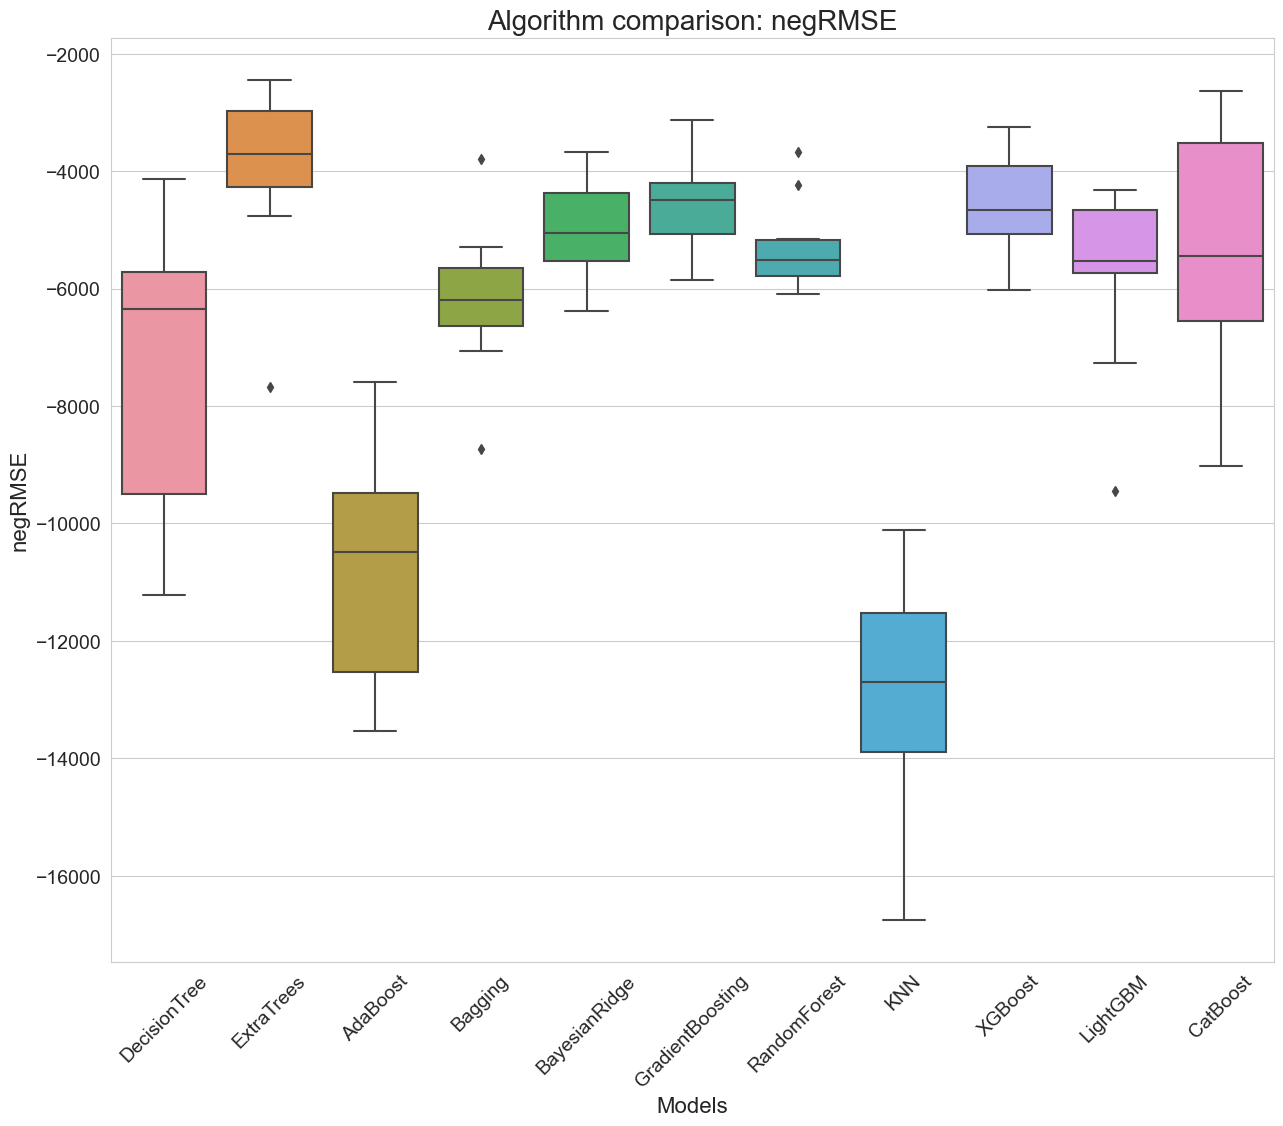

In [33]:
plot = pd.DataFrame(resultados[5:], index=nombres[5:]).T

sns.set_style("whitegrid")
plt.figure(figsize=(15, 12))
sns.boxplot(data=plot)
plt.title('Algorithm comparison: negRMSE', fontsize=20)
plt.xlabel('Models', fontsize=16)
plt.ylabel('negRMSE', fontsize=16)
plt.xticks(rotation=45, fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In this plot we conclude that the model to be chosen is `ExtraTrees`.

## Using Optuna for Hyperparameter Tuning 

In [34]:
def objective(trial):
    """
    Find the optimal parameters for the objective loss function.
    """
    params = {
        'iterations': trial.suggest_int('iterations', 100, 500),
        'depth': trial.suggest_int('depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.9),
        # Add regularization
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.1, 20),  
        'border_count': trial.suggest_int('border_count', 32, 255),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 10),
    }
    model = CatBoostRegressor(**params, verbose=0)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return np.sqrt(mse)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Best parameters: ", study.best_params)
print("Best score: ", study.best_value)

[I 2023-09-08 11:52:11,588] A new study created in memory with name: no-name-6cbd1fc1-440e-452a-8653-bc77dec38d73
[W 2023-09-08 11:52:11,598] Trial 0 failed with parameters: {'iterations': 303, 'depth': 5, 'learning_rate': 0.05880025920648361, 'l2_leaf_reg': 0.5155907071149564, 'border_count': 243, 'min_data_in_leaf': 1} because of the following error: TypeError("ExtraTreesRegressor.__init__() got an unexpected keyword argument 'iterations'").
Traceback (most recent call last):
  File "c:\Users\Aneur\Miniconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\Aneur\AppData\Local\Temp\ipykernel_3516\2472858654.py", line 14, in objective
    model = ExtraTreesRegressor(**params, verbose=0)
TypeError: ExtraTreesRegressor.__init__() got an unexpected keyword argument 'iterations'
[W 2023-09-08 11:52:11,607] Trial 0 failed with value None.


TypeError: ExtraTreesRegressor.__init__() got an unexpected keyword argument 'iterations'

Train the model with the optimized hyperparameters

In [182]:
best_params = study.best_params
best_params.update({
    'od_type': 'Iter',
    'od_wait': 50,
    'eval_metric': 'RMSE',
    'verbose': False
})
model = CatBoostRegressor(**best_params)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
y_pred = model.predict(X_test)

Get the RMSE

In [183]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 2.079738181327106


Get model R squared

In [184]:
r2 = model.score(X_test, y_test)
print(f"R-squared: {r2}")

R-squared: 0.8286234788526352


In [ ]:
evals_result = model.get_evals_result()

# Get RMSE
train_rmse = evals_result['learn']['RMSE']
valid_rmse = evals_result['validation']['RMSE']

plt.figure(figsize=(10, 5))
plt.plot(train_rmse, label='RMSE training')
plt.plot(valid_rmse, label='RMSE validation')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.legend()
plt.title('Training loss and validation graphs')
plt.show()

## Model evaluation and explicability

Metric obtained: `RMSE` = 

In [ ]:
explainer = shap.Explainer(model)

shap_values = explainer.shap_values(X_test)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0, :], X_test.iloc[0, :])

shap.summary_plot(shap_values, X_test)